**Student Name:** Phạm Thành Đạt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

print("=== Loading Data ===")
customers = pd.read_csv('customers.csv')
events = pd.read_csv('events.csv')
offers = pd.read_csv('offers.csv')

=== Loading Data ===


In [ ]:
print("\n=== PART 1: ANALYZING CUSTOMERS DATA ===")

# 1. Initial Analysis
print("\nInitial Customers Info:")
print(customers.info())
print("\nMissing Values:")
print(customers.isnull().sum())
print("\nDescriptive Statistics:")
print(customers.describe())


=== PART 1: ANALYZING CUSTOMERS DATA ===

Initial Customers Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       17000 non-null  object 
 1   became_member_on  17000 non-null  int64  
 2   gender            14825 non-null  object 
 3   age               17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None

Missing Values:
customer_id            0
became_member_on       0
gender              2175
age                    0
income              2175
dtype: int64

Descriptive Statistics:
       became_member_on           age         income
count      1.700000e+04  17000.000000   14825.000000
mean       2.016703e+07     62.531412   65404.991568
std        1.167750e+04     26.738580   21598.299410
min        2.013073e+07     18.0000

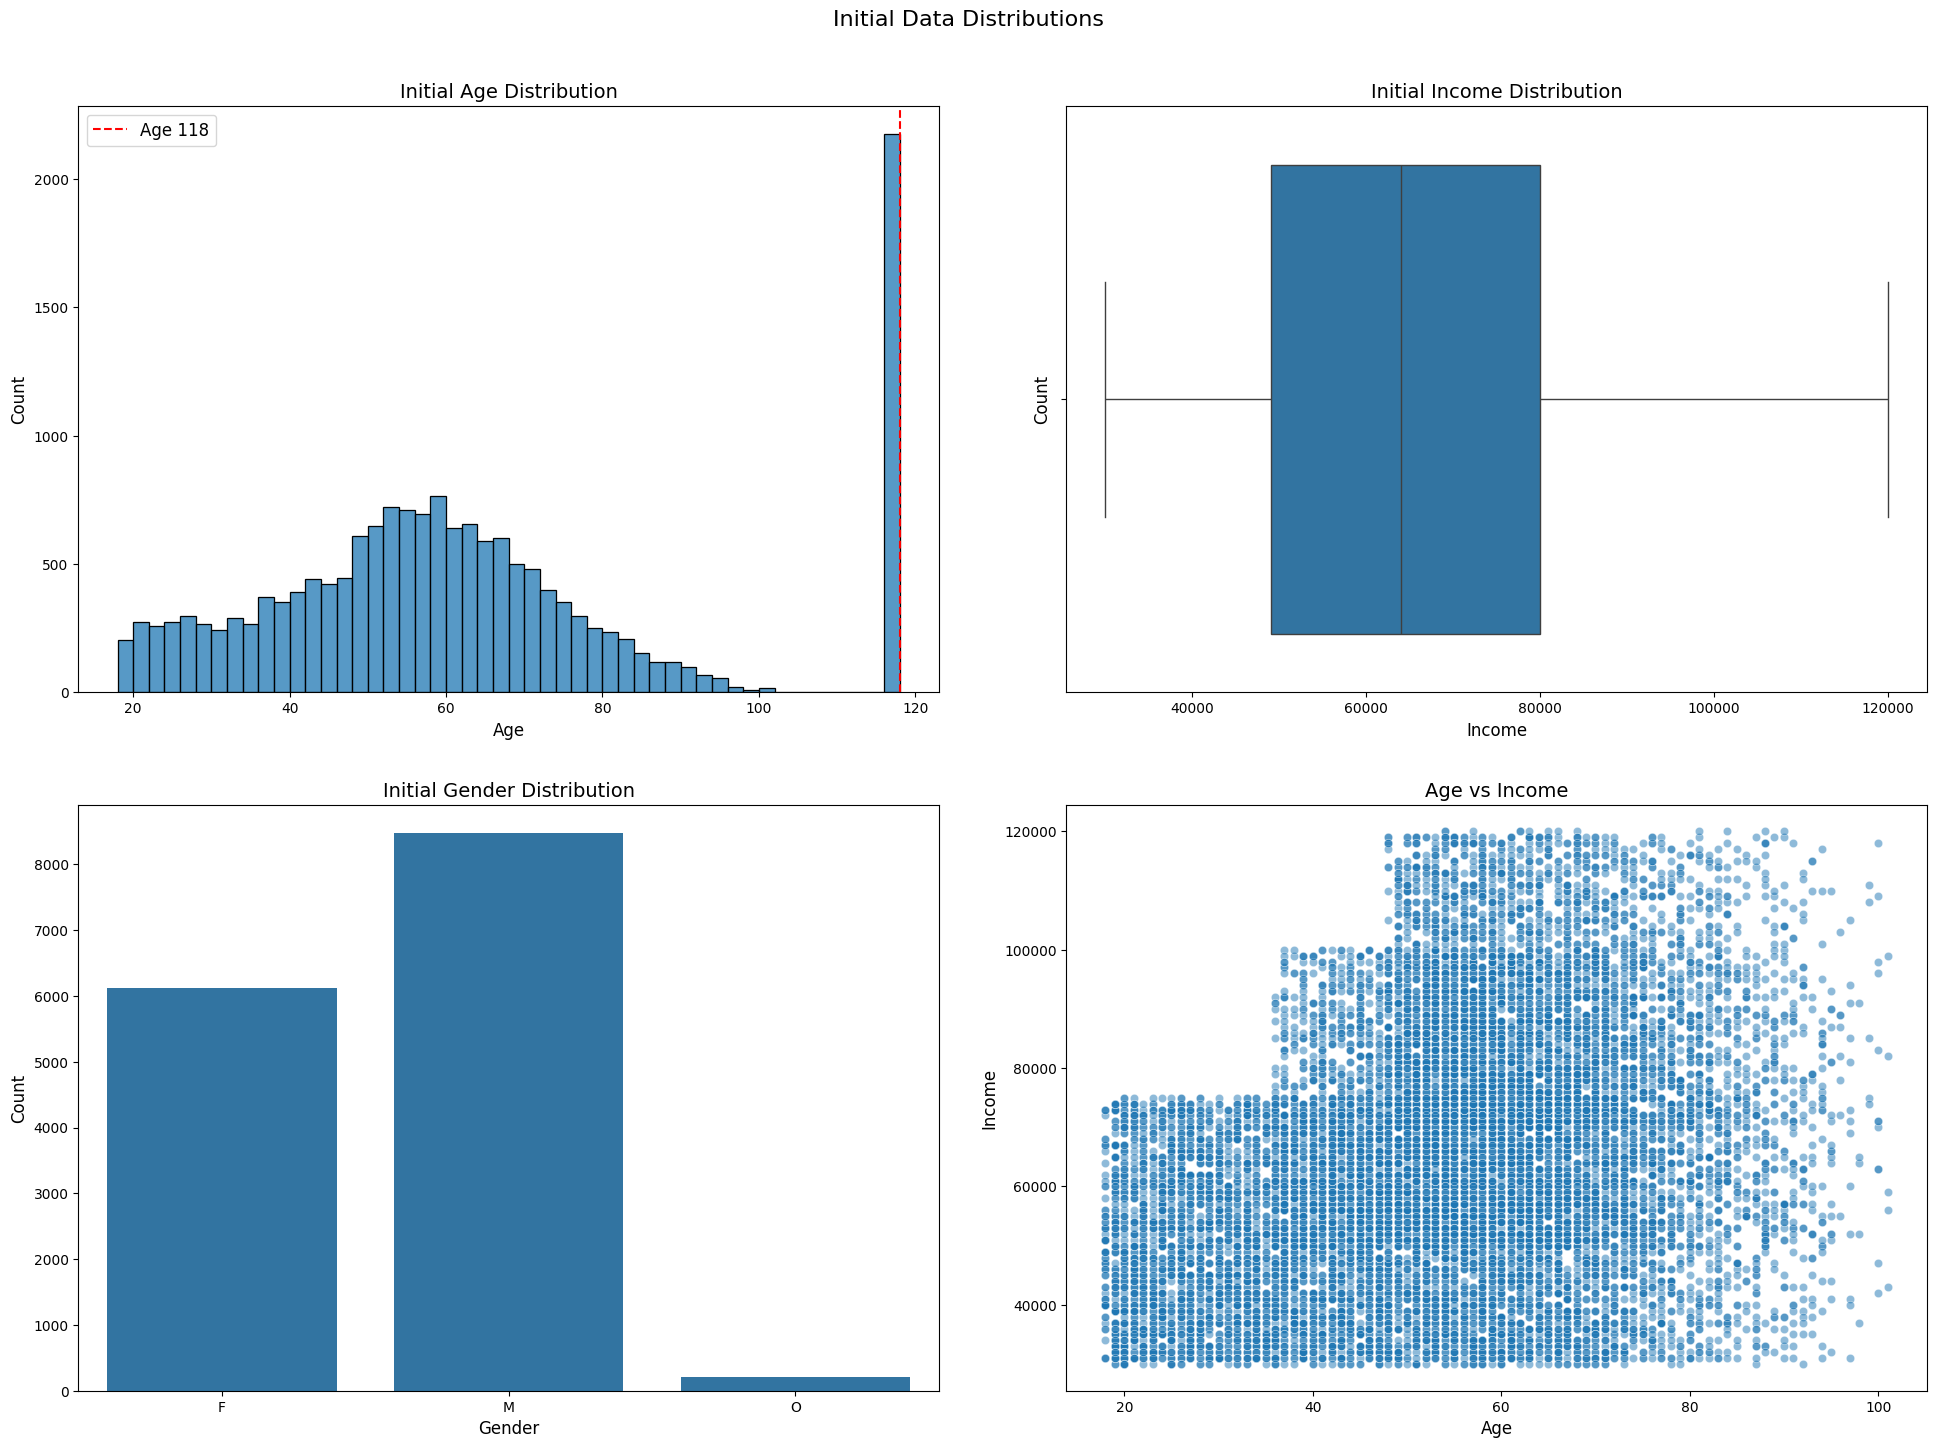

In [ ]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Initial Data Distributions', fontsize=16)

# Age Distribution
sns.histplot(data=customers, x='age', bins=50, ax=axes[0,0])
axes[0,0].set_title('Initial Age Distribution', fontsize=14)
axes[0,0].axvline(x=118, color='r', linestyle='--', label='Age 118')
axes[0,0].legend(fontsize=12)
axes[0,0].set_xlabel('Age', fontsize=12)
axes[0,0].set_ylabel('Count', fontsize=12)

# Income Distribution
sns.boxplot(data=customers, x='income', ax=axes[0,1])
axes[0,1].set_title('Initial Income Distribution', fontsize=14)
axes[0,1].set_xlabel('Income', fontsize=12)
axes[0,1].set_ylabel('Count', fontsize=12)

# Gender Distribution
sns.countplot(data=customers, x='gender', ax=axes[1,0])
axes[1,0].set_title('Initial Gender Distribution', fontsize=14)
axes[1,0].set_xlabel('Gender', fontsize=12)
axes[1,0].set_ylabel('Count', fontsize=12)

# Age vs Income
sns.scatterplot(data=customers, x='age', y='income', alpha=0.5, ax=axes[1,1])
axes[1,1].set_title('Age vs Income', fontsize=14)
axes[1,1].set_xlabel('Age', fontsize=12)
axes[1,1].set_ylabel('Income', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()



=== Processing Gender ===

Original gender distribution:
gender
M    0.572277
F    0.413423
O    0.014300
Name: proportion, dtype: float64

Processed gender distribution:
gender
M    0.571471
F    0.414059
O    0.014471
Name: proportion, dtype: float64


<Figure size 1000x600 with 0 Axes>

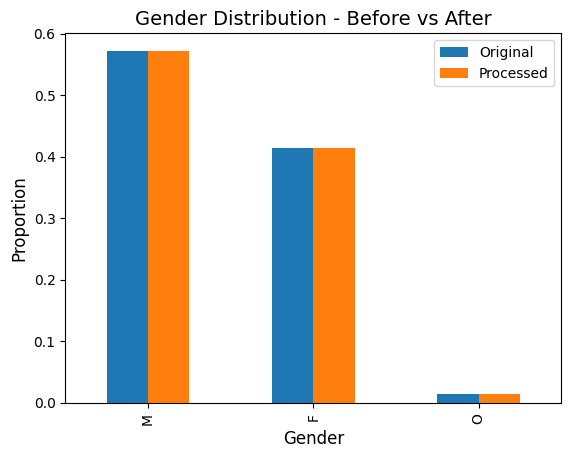

In [ ]:
# 2. Process Gender (Start with simplest)
print("\n=== Processing Gender ===")
df = customers.copy()
print("\nOriginal gender distribution:")
print(df['gender'].value_counts(normalize=True))

# Fill missing gender based on distribution
gender_dist = df['gender'].value_counts(normalize=True)
missing_gender_mask = df['gender'].isnull()
n_missing = missing_gender_mask.sum()

np.random.seed(42)
df.loc[missing_gender_mask, 'gender'] = np.random.choice(
    gender_dist.index,
    size=n_missing,
    p=gender_dist.values
)

print("\nProcessed gender distribution:")
print(df['gender'].value_counts(normalize=True))

# Verify gender distribution
plt.figure(figsize=(10, 6))
gender_comparison = pd.DataFrame({
    'Original': customers['gender'].value_counts(normalize=True),
    'Processed': df['gender'].value_counts(normalize=True)
})
gender_comparison.plot(kind='bar')
plt.title('Gender Distribution - Before vs After', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend()
plt.show()


=== Processing Age ===
Age statistics before processing:
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


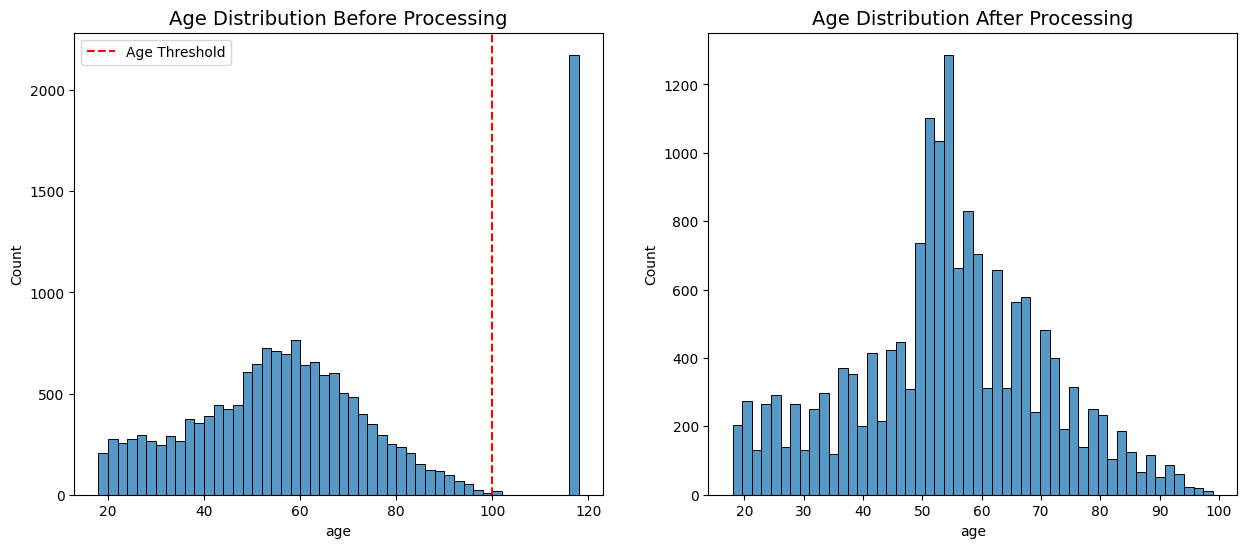


Age statistics after processing:
count    17000.000000
mean        54.221088
std         16.188339
min         18.000000
25%         45.000000
50%         54.004684
75%         65.000000
max         99.000000
Name: age, dtype: float64


In [ ]:
# 3. Process Age
print("\n=== Processing Age ===")
print("Age statistics before processing:")
print(df['age'].describe())

# Identify valid ages
age_mask = (df['age'] < 100) & (df['age'] >= 18)
valid_ages = df.loc[age_mask, 'age']

# Visualize age distributions
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.histplot(data=df, x='age', bins=50)
plt.title('Age Distribution Before Processing', fontsize=14)
plt.axvline(x=100, color='r', linestyle='--', label='Age Threshold')
plt.legend()

# Train Random Forest for age prediction
age_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Temporarily fill income for age prediction
df['income_temp'] = df['income'].fillna(df['income'].median())

# Train on valid ages
age_train = df.loc[age_mask, ['income_temp']]
age_target = df.loc[age_mask, 'age']
age_model.fit(age_train, age_target)

# Predict ages for invalid entries
invalid_age_mask = ~age_mask
age_predictions = age_model.predict(df.loc[invalid_age_mask, ['income_temp']])

# Add noise and clip
noise = np.random.normal(0, 2, size=len(age_predictions))
df.loc[invalid_age_mask, 'age'] = np.clip(age_predictions + noise, 18, 100)

# Visualize processed age
plt.subplot(1,2,2)
sns.histplot(data=df, x='age', bins=50)
plt.title('Age Distribution After Processing', fontsize=14)
plt.show()

print("\nAge statistics after processing:")
print(df['age'].describe())



=== Processing Income ===
Income statistics before processing:
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


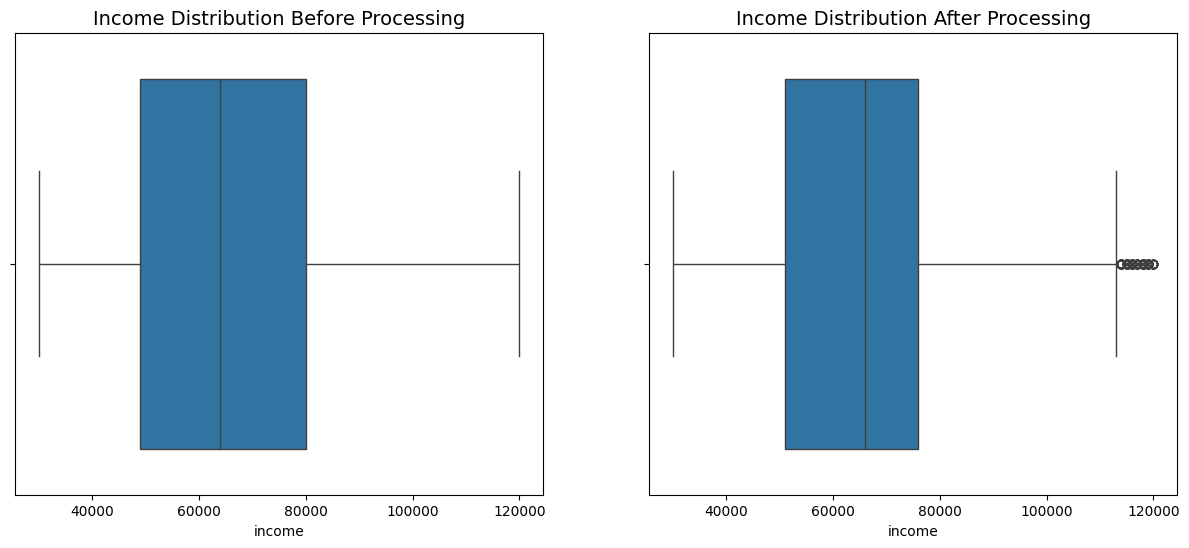


Income statistics after processing:
count     17000.000000
mean      65784.178877
std       20273.730684
min       30000.000000
25%       51000.000000
50%       66000.000000
75%       76000.000000
max      120000.000000
Name: income, dtype: float64


In [ ]:
# 4. Process Income
print("\n=== Processing Income ===")
print("Income statistics before processing:")
print(df['income'].describe())

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.boxplot(data=df, x='income')
plt.title('Income Distribution Before Processing', fontsize=14)

# Train Random Forest for income
income_model = RandomForestRegressor(n_estimators=100, random_state=42)
income_missing_mask = df['income'].isnull()

# Prepare training data
income_train = df.loc[~income_missing_mask, ['age']]
income_target = df.loc[~income_missing_mask, 'income']
income_model.fit(income_train, income_target)

# Predict and add noise
income_predictions = income_model.predict(df.loc[income_missing_mask, ['age']])
income_noise = np.random.normal(0, 1000, size=len(income_predictions))

# Clip to reasonable range using percentiles
lower_bound = df['income'].quantile(0.01)
upper_bound = df['income'].quantile(0.99)

df.loc[income_missing_mask, 'income'] = np.clip(
    income_predictions + income_noise,
    lower_bound,
    upper_bound
)

# Drop temporary column
df.drop('income_temp', axis=1, inplace=True)

# Visualize processed income
plt.subplot(1,2,2)
sns.boxplot(data=df, x='income')
plt.title('Income Distribution After Processing', fontsize=14)
plt.show()

print("\nIncome statistics after processing:")
print(df['income'].describe())

# Save processed customers data
customers_processed = df.copy()

In [ ]:
print("\n=== PART 2: PROCESSING EVENTS DATA ===")
print("\nEvents data info:")
print(events.info())
print("\nEvent types:")
print(events['event'].value_counts())



=== PART 2: PROCESSING EVENTS DATA ===

Events data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None

Event types:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


In [ ]:
# 2. Process value column
def parse_value(row):
    try:
        if isinstance(row['value'], str):
            value_dict = eval(row['value'])
        else:
            value_dict = row['value']

        if row['event'] == 'transaction':
            return pd.Series({
                'offer_id': None,
                'amount': value_dict.get('amount'),
                'reward': None
            })
        elif row['event'] == 'offer completed':
            return pd.Series({
                'offer_id': value_dict.get('offer_id') or value_dict.get('offer id'),
                'amount': None,
                'reward': value_dict.get('reward')
            })
        elif row['event'] in ['offer received', 'offer viewed']:
            return pd.Series({
                'offer_id': value_dict.get('offer_id') or value_dict.get('offer id'),
                'amount': None,
                'reward': None
            })
        return pd.Series({'offer_id': None, 'amount': None, 'reward': None})
    except:
        return pd.Series({'offer_id': None, 'amount': None, 'reward': None})

# Process events
events_processed = events.copy()
parsed_values = events_processed.apply(parse_value, axis=1)
events_processed = pd.concat([
    events_processed.drop('value', axis=1),
    parsed_values
], axis=1)

In [ ]:
# 3. Handle Multiple Offers
# Add time information
events_processed['day'] = events_processed['time'] // 24

# Merge with offers to get duration
offer_events = pd.merge(
    events_processed[events_processed['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
    offers[['offer_id', 'duration']],
    on='offer_id',
    how='left'
)

# Calculate offer windows
offer_events['end_day'] = offer_events.apply(
    lambda x: x['day'] + x['duration'] if x['event'] == 'offer received' else x['day'],
    axis=1
)

# Mark valid completions
valid_completions = []
for _, completion in events_processed[events_processed['event'] == 'offer completed'].iterrows():
    # Find corresponding received offer
    received_offer = offer_events[
        (offer_events['customer_id'] == completion['customer_id']) &
        (offer_events['offer_id'] == completion['offer_id']) &
        (offer_events['event'] == 'offer received') &
        (offer_events['day'] <= completion['day']) &
        (offer_events['end_day'] >= completion['day'])
    ]

    if not received_offer.empty:
        valid_completions.append({
            'customer_id': completion['customer_id'],
            'offer_id': completion['offer_id'],
            'day': completion['day']
        })

valid_completions_df = pd.DataFrame(valid_completions)

# Update events_processed
events_processed['valid_completion'] = events_processed.apply(
    lambda x: x['event'] != 'offer completed' or
    any((valid_completions_df['customer_id'] == x['customer_id']) &
        (valid_completions_df['offer_id'] == x['offer_id']) &
        (valid_completions_df['day'] == x['day'])),
    axis=1
)

In [ ]:
# Final verification
print("\n=== Final Data Quality Check ===")
print("\nProcessed Customers Data:")
print(customers_processed.isnull().sum())
print("\nProcessed Events Data:")
print(events_processed.isnull().sum())


=== Final Data Quality Check ===

Processed Customers Data:
customer_id         0
became_member_on    0
gender              0
age                 0
income              0
dtype: int64

Processed Events Data:
customer_id              0
event                    0
time                     0
offer_id            138953
amount              167581
reward              272955
day                      0
valid_completion         0
dtype: int64


In [ ]:
customers_processed.to_csv('customers_processed.csv', index=False)
events_processed.to_csv('events_processed.csv', index=False)
print("\nProcessed data saved to CSV files")


Processed data saved to CSV files


In [ ]:
print("\nFinal Statistics:")
print("\nValid Completions:", len(valid_completions))
print("\nEvent Types Distribution:")
print(events_processed[events_processed['valid_completion']]['event'].value_counts())


Final Statistics:

Valid Completions: 33579

Event Types Distribution:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


In [ ]:
print("=== Analyzing Offer Type Performance ===")

offer_performance = pd.merge(
    events_processed[events_processed['valid_completion'] == True], 
    offers[['offer_id', 'offer_type']],
    on='offer_id',
    how='left'
)

=== Analyzing Offer Type Performance ===


In [ ]:
# 2. Calculate metrics by offer type
metrics_by_type = pd.DataFrame()

for offer_type in offers['offer_type'].unique():
    type_data = offer_performance[offer_performance['offer_type'] == offer_type]
    received = type_data[type_data['event'] == 'offer received'].shape[0]
    viewed = type_data[type_data['event'] == 'offer viewed'].shape[0]
    completed = type_data[type_data['event'] == 'offer completed'].shape[0]
    metrics_by_type.loc[offer_type, 'Total Sent'] = received
    metrics_by_type.loc[offer_type, 'Total Viewed'] = viewed
    metrics_by_type.loc[offer_type, 'Total Completed'] = completed
    metrics_by_type.loc[offer_type, 'View Rate (%)'] = round((viewed/received)*100, 2) if received > 0 else 0
    metrics_by_type.loc[offer_type, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
    metrics_by_type.loc[offer_type, 'Success Rate (%)'] = round((completed/received)*100, 2) if received > 0 else 0

print("\nOffer Type Performance Metrics:")
print(metrics_by_type)


Offer Type Performance Metrics:
               Total Sent  Total Viewed  Total Completed  View Rate (%)  \
bogo              30499.0       25449.0          15669.0          83.44   
informational     15235.0       10831.0              0.0          71.09   
discount          30543.0       21445.0          17910.0          70.21   

               Completion Rate (%)  Success Rate (%)  
bogo                         61.57             51.38  
informational                 0.00              0.00  
discount                     83.52             58.64  


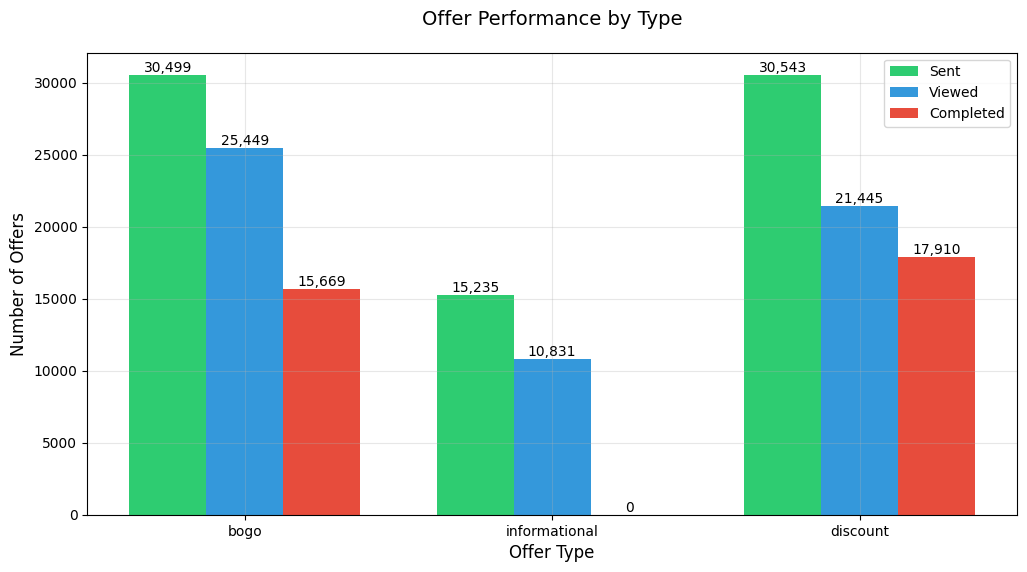

In [ ]:
# 3. Visualizations
# 3.1 Bar Chart - Absolute Numbers
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_by_type.index))
width = 0.25

sent_bars = plt.bar(x - width, metrics_by_type['Total Sent'], width,
                   label='Sent', color='#2ecc71')
viewed_bars = plt.bar(x, metrics_by_type['Total Viewed'], width,
                     label='Viewed', color='#3498db')
completed_bars = plt.bar(x + width, metrics_by_type['Total Completed'], width,
                        label='Completed', color='#e74c3c')

plt.title('Offer Performance by Type', fontsize=14, pad=20)
plt.xlabel('Offer Type', fontsize=12)
plt.ylabel('Number of Offers', fontsize=12)
plt.xticks(x, metrics_by_type.index)
plt.legend()
for i, bars in enumerate(zip(sent_bars, viewed_bars, completed_bars)):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.show()

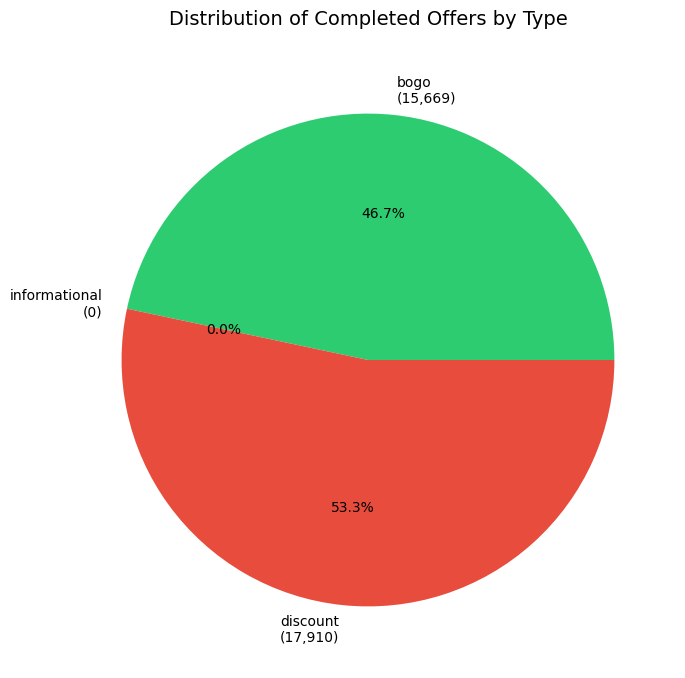

In [ ]:
# 3.2 Pie Chart - Completion Distribution
plt.figure(figsize=(10, 8))
completion_data = metrics_by_type['Total Completed']
plt.pie(completion_data,
        labels=[f"{idx}\n({val:,.0f})" for idx, val in zip(completion_data.index, completion_data)],
        autopct='%1.1f%%',
        colors=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Distribution of Completed Offers by Type', pad=20, fontsize=14)
plt.show()


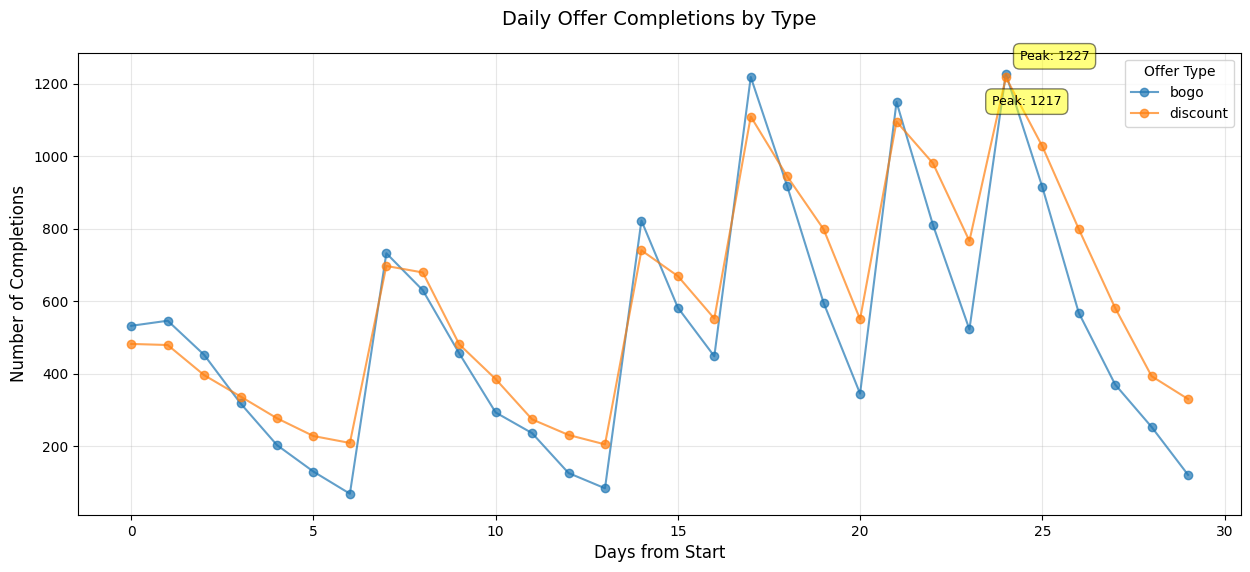

In [ ]:
# 3.3 Line Chart - Time Trend
offer_performance['day'] = offer_performance['time'] // 24
daily_completions = pd.pivot_table(
    offer_performance[offer_performance['event'] == 'offer completed'],
    index='day',
    columns='offer_type',
    values='event',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(15, 6))
offset_direction = {'bogo': (10, 10), 'discount': (-10, -20)}
for offer_type in daily_completions.columns:
    plt.plot(daily_completions.index, daily_completions[offer_type],
             marker='o', label=offer_type, alpha=0.7)

plt.title('Daily Offer Completions by Type', pad=20, fontsize=14)
plt.xlabel('Days from Start', fontsize=12)
plt.ylabel('Number of Completions', fontsize=12)
plt.legend(title='Offer Type')
plt.grid(True, alpha=0.3)

for offer_type in daily_completions.columns:
    peak_day = daily_completions[offer_type].idxmax()
    peak_value = daily_completions[offer_type].max()
    offset = offset_direction[offer_type] 
    plt.annotate(f'Peak: {int(peak_value)}',
                 (peak_day, peak_value),
                 xytext=offset,
                 textcoords='offset points',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

In [ ]:
print("\n=== Key Performance Insights ===")
print("\nBest Performing Offer Types:")
print(f"Highest View Rate: {metrics_by_type['View Rate (%)'].idxmax()} " +
      f"({metrics_by_type['View Rate (%)'].max():.1f}%)")
print(f"Highest Completion Rate: {metrics_by_type['Completion Rate (%)'].idxmax()} " +
      f"({metrics_by_type['Completion Rate (%)'].max():.1f}%)")
print(f"Best Overall Success Rate: {metrics_by_type['Success Rate (%)'].idxmax()} " +
      f"({metrics_by_type['Success Rate (%)'].max():.1f}%)")


=== Key Performance Insights ===

Best Performing Offer Types:
Highest View Rate: bogo (83.4%)
Highest Completion Rate: discount (83.5%)
Best Overall Success Rate: discount (58.6%)


In [ ]:
metrics_by_type['Effectiveness Score'] = (
    metrics_by_type['View Rate (%)'] * 0.4 +
    metrics_by_type['Completion Rate (%)'] * 0.6
).round(2)

print("\nEffectiveness Ranking:")
print(metrics_by_type['Effectiveness Score'].sort_values(ascending=False))


Effectiveness Ranking:
discount         78.20
bogo             70.32
informational    28.44
Name: Effectiveness Score, dtype: float64


In [ ]:
print("\n=== Analyzing Offer Difficulty Effectiveness ===")
difficulty_performance = pd.merge(
    events_processed[events_processed['offer_id'].notna()],  # Chỉ lấy rows có offer_id
    offers[['offer_id', 'difficulty', 'reward']],
    on='offer_id',
    how='left'
)
print("\nUnique difficulty levels:")
print(difficulty_performance['difficulty'].unique())
print("\nDifficulty value counts:")
print(difficulty_performance['difficulty'].value_counts())


=== Analyzing Offer Difficulty Effectiveness ===

Unique difficulty levels:
[ 5 20 10  7  0]

Difficulty value counts:
difficulty
10    72292
5     35333
0     26066
7     20139
20    13751
Name: count, dtype: int64


In [ ]:
# 2. Calculate metrics by difficulty
metrics_by_diff = pd.DataFrame()
valid_difficulties = difficulty_performance['difficulty'].dropna().unique()

for diff in sorted(valid_difficulties):
    diff_data = difficulty_performance[difficulty_performance['difficulty'] == diff]
    received = diff_data[diff_data['event'] == 'offer received'].shape[0]
    viewed = diff_data[diff_data['event'] == 'offer viewed'].shape[0]
    completed = diff_data[diff_data['event'] == 'offer completed'].shape[0]
    spend_label = f"${int(diff)}"
    metrics_by_diff.loc[spend_label, 'Total Sent'] = received
    metrics_by_diff.loc[spend_label, 'Total Viewed'] = viewed
    metrics_by_diff.loc[spend_label, 'Total Completed'] = completed
    metrics_by_diff.loc[spend_label, 'View Rate (%)'] = round((viewed/received)*100, 2) if received > 0 else 0
    metrics_by_diff.loc[spend_label, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
    metrics_by_diff.loc[spend_label, 'Success Rate (%)'] = round((completed/received)*100, 2) if received > 0 else 0

print("\nDifficulty Level Performance Metrics:")
print(metrics_by_diff)


Difficulty Level Performance Metrics:
     Total Sent  Total Viewed  Total Completed  View Rate (%)  \
$0      15235.0       10831.0              0.0          71.09   
$5      15248.0       11435.0           8650.0          74.99   
$7       7646.0        7337.0           5156.0          95.96   
$10     30480.0       25459.0          16353.0          83.53   
$20      7668.0        2663.0           3420.0          34.73   

     Completion Rate (%)  Success Rate (%)  
$0                  0.00              0.00  
$5                 75.64             56.73  
$7                 70.27             67.43  
$10                64.23             53.65  
$20               128.43             44.60  


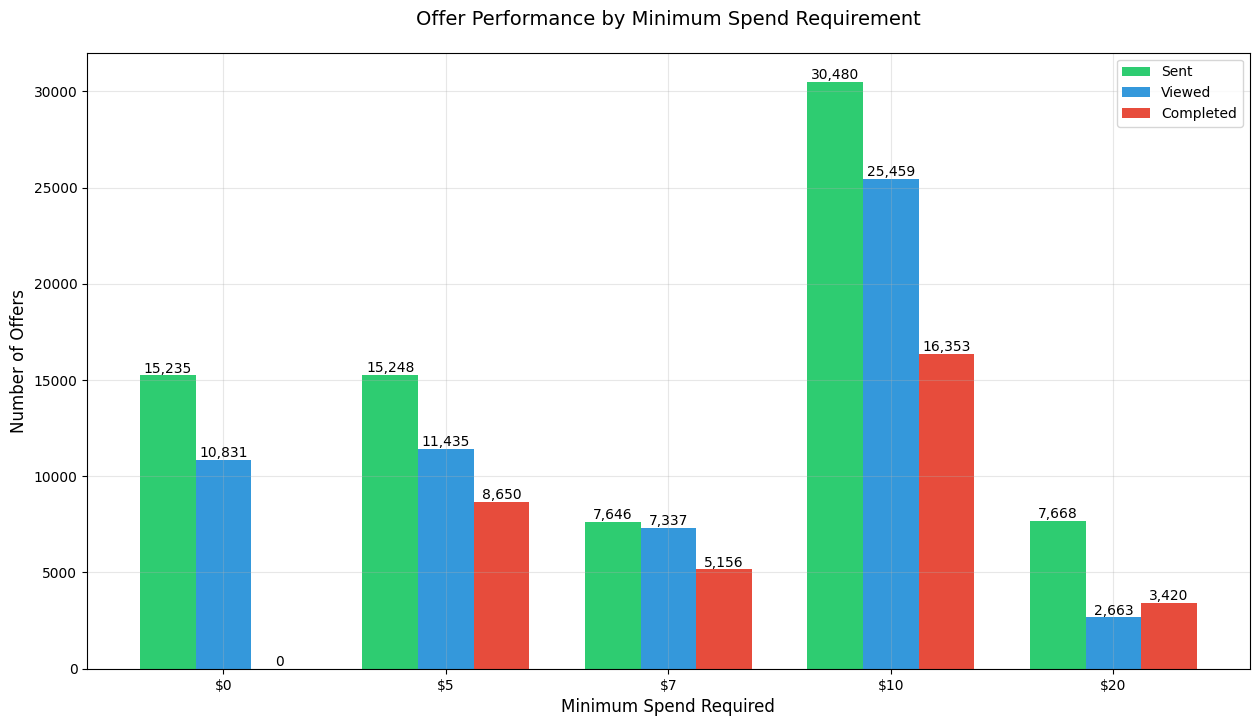

In [ ]:
# 3. Visualizations
# 3.1 Bar Chart - Absolute Numbers with Rate Labels
plt.figure(figsize=(15, 8))
x = np.arange(len(metrics_by_diff.index))
width = 0.25

sent_bars = plt.bar(x - width, metrics_by_diff['Total Sent'], width,
                   label='Sent', color='#2ecc71')
viewed_bars = plt.bar(x, metrics_by_diff['Total Viewed'], width,
                     label='Viewed', color='#3498db')
completed_bars = plt.bar(x + width, metrics_by_diff['Total Completed'], width,
                        label='Completed', color='#e74c3c')

plt.title('Offer Performance by Minimum Spend Requirement', pad=20, fontsize=14)
plt.xlabel('Minimum Spend Required', fontsize=12)
plt.ylabel('Number of Offers', fontsize=12)
plt.xticks(x, metrics_by_diff.index)
plt.legend()
for i, bars in enumerate(zip(sent_bars, viewed_bars, completed_bars)):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

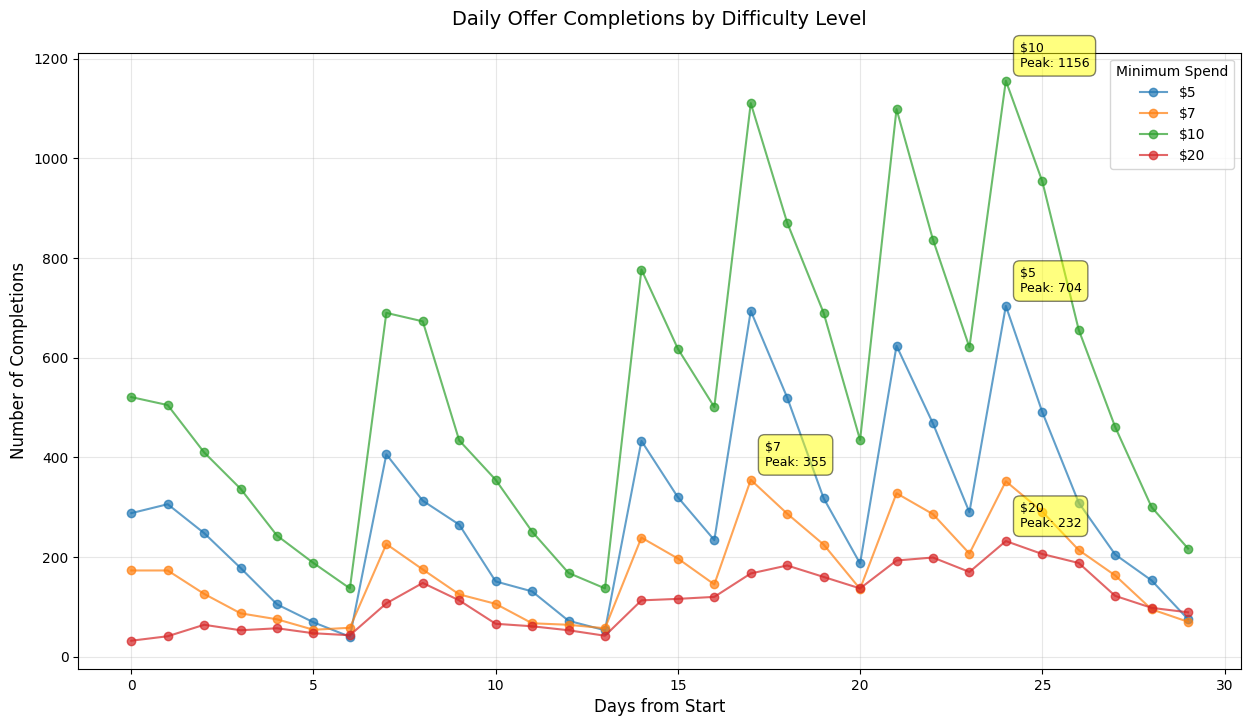

In [ ]:
# 3.2 Line Chart - Time Trend by Difficulty
difficulty_performance['day'] = difficulty_performance['time'] // 24

daily_completions = pd.pivot_table(
    difficulty_performance[
        (difficulty_performance['event'] == 'offer completed') &
        (difficulty_performance['difficulty'].notna())
    ],
    index='day',
    columns='difficulty',
    values='event',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(15, 8))
for diff in sorted(daily_completions.columns):
    plt.plot(daily_completions.index, daily_completions[diff],
             marker='o', label=f'${int(diff)}', alpha=0.7)

plt.title('Daily Offer Completions by Difficulty Level', pad=20, fontsize=14)
plt.xlabel('Days from Start', fontsize=12)
plt.ylabel('Number of Completions', fontsize=12)
plt.legend(title='Minimum Spend')
for diff in daily_completions.columns:
    data = daily_completions[diff]
    peak_day = data.idxmax()
    peak_value = data.max()

    if peak_value > 0:
        plt.annotate(f'${int(diff)}\nPeak: {int(peak_value)}',
                    (peak_day, peak_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1200x600 with 0 Axes>

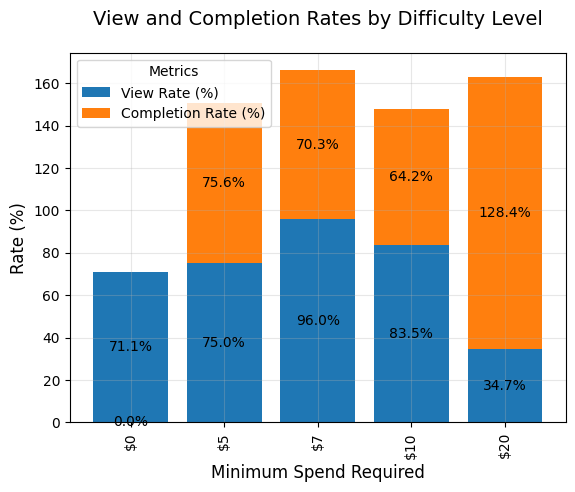

In [ ]:
# 3.3 Stacked Bar Chart - Success Rates
plt.figure(figsize=(12, 6))
rates = metrics_by_diff[['View Rate (%)', 'Completion Rate (%)']]
ax = rates.plot(kind='bar', stacked=True, width=0.8)
plt.title('View and Completion Rates by Difficulty Level', pad=20, fontsize=14)
plt.xlabel('Minimum Spend Required', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)
plt.legend(title='Metrics')
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# 4. ROI Analysis
print("\n=== ROI Analysis ===")

# Merge với offers để lấy reward info
performance_with_reward = pd.merge(
    difficulty_performance,
    offers[['offer_id', 'difficulty', 'reward']],
    on=['offer_id', 'difficulty'],
    how='left'
)

print("\nVerify data:")
print("Columns after merge:", performance_with_reward.columns.tolist())
print("\nSample data:")
print(performance_with_reward[['offer_id', 'difficulty', 'reward', 'event']].head())


=== ROI Analysis ===

Verify data:
Columns after merge: ['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x', 'day', 'valid_completion', 'difficulty', 'reward_y', 'reward']

Sample data:
                           offer_id  difficulty  reward           event
0  9b98b8c7a33c4b65b9aebfe6a799e6d9           5       5  offer received
1  0b1e1539f2cc45b7b9fa7c272da2e1d7          20       5  offer received
2  2906b810c7d4411798c6938adc9daaa5          10       2  offer received
3  fafdcd668e3743c1bb461111dcafc2a4          10       2  offer received
4  4d5c57ea9a6940dd891ad53e9dbe8da0          10      10  offer received


In [ ]:
# Calculate ROI by difficulty
roi_analysis = pd.DataFrame()
for diff in sorted(valid_difficulties):
    completed_offers = performance_with_reward[
        (performance_with_reward['difficulty'] == diff) &
        (performance_with_reward['event'] == 'offer completed')
    ]
    spend_label = f"${int(diff)}"
    total_reward = completed_offers['reward'].sum()
    n_completions = len(completed_offers)
    total_required_spend = diff * n_completions

    roi_analysis.loc[spend_label, 'Number of Completions'] = n_completions
    roi_analysis.loc[spend_label, 'Total Reward'] = total_reward
    roi_analysis.loc[spend_label, 'Total Required Spend'] = total_required_spend
    roi_analysis.loc[spend_label, 'ROI (%)'] = round(
        (total_reward / total_required_spend * 100) if total_required_spend > 0 else 0,
        2
    )

print("\nROI Analysis by Difficulty Level:")
print(roi_analysis)


ROI Analysis by Difficulty Level:
     Number of Completions  Total Reward  Total Required Spend  ROI (%)
$0                     0.0           0.0                   0.0     0.00
$5                  8650.0       43250.0               43250.0   100.00
$7                  5156.0       15468.0               36092.0    42.86
$10                16353.0       88858.0              163530.0    54.34
$20                 3420.0       17100.0               68400.0    25.00


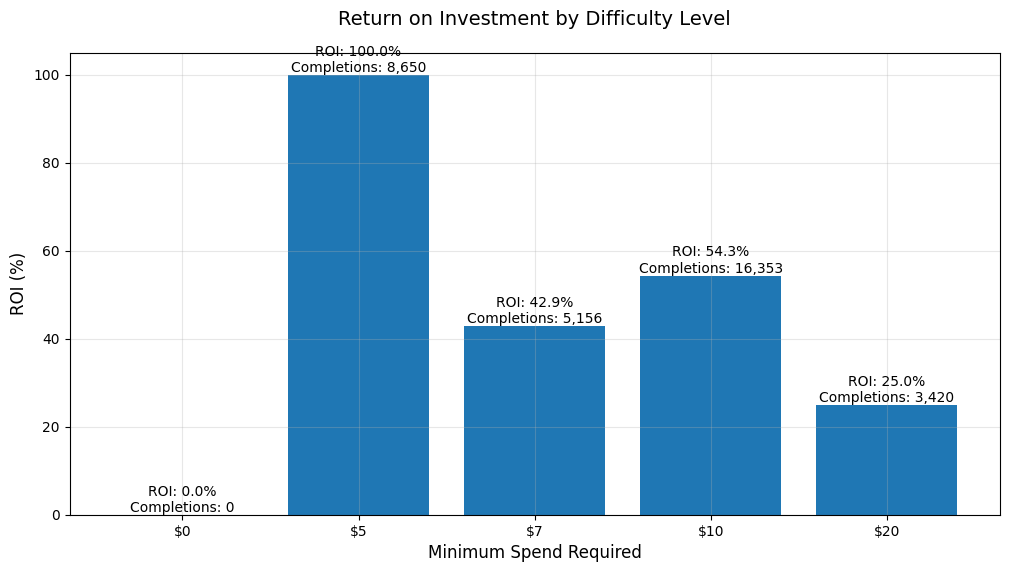

In [ ]:
# Visualize ROI Analysis
plt.figure(figsize=(12, 6))

# Bar chart of ROI
roi_bars = plt.bar(roi_analysis.index, roi_analysis['ROI (%)'])
plt.title('Return on Investment by Difficulty Level', pad=20, fontsize=14)
plt.xlabel('Minimum Spend Required', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)
for i, roi_bar in enumerate(roi_bars):
    height = roi_bar.get_height()
    completions = roi_analysis['Number of Completions'].iloc[i]
    plt.text(
        roi_bar.get_x() + roi_bar.get_width()/2.,
        height,
        f'ROI: {height:.1f}%\nCompletions: {int(completions):,}',
        ha='center',
        va='bottom'
    )

plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Calculate Additional Metrics
roi_analysis['Reward per Completion'] = (
    roi_analysis['Total Reward'] / roi_analysis['Number of Completions']
).round(2)

roi_analysis['Required Spend per Completion'] = (
    roi_analysis['Total Required Spend'] / roi_analysis['Number of Completions']
).round(2)

print("\nDetailed ROI Metrics:")
print(roi_analysis)


Detailed ROI Metrics:
     Number of Completions  Total Reward  Total Required Spend  ROI (%)  \
$0                     0.0           0.0                   0.0     0.00   
$5                  8650.0       43250.0               43250.0   100.00   
$7                  5156.0       15468.0               36092.0    42.86   
$10                16353.0       88858.0              163530.0    54.34   
$20                 3420.0       17100.0               68400.0    25.00   

     Reward per Completion  Required Spend per Completion  
$0                     NaN                            NaN  
$5                    5.00                            5.0  
$7                    3.00                            7.0  
$10                   5.43                           10.0  
$20                   5.00                           20.0  


In [ ]:
# Find optimal difficulty levels
best_roi = roi_analysis['ROI (%)'].idxmax()
most_completions = roi_analysis['Number of Completions'].idxmax()
highest_total_reward = roi_analysis['Total Reward'].idxmax()

print("\nOptimal Difficulty Levels:")
print(f"Best ROI: {best_roi} ({roi_analysis.loc[best_roi, 'ROI (%)']}%)")
print(f"Most Completions: {most_completions} ({int(roi_analysis.loc[most_completions, 'Number of Completions']):,})")
print(f"Highest Total Reward: {highest_total_reward} (${roi_analysis.loc[highest_total_reward, 'Total Reward']:,.2f})")



Optimal Difficulty Levels:
Best ROI: $5 (100.0%)
Most Completions: $10 (16,353)
Highest Total Reward: $10 ($88,858.00)


In [ ]:
print("\n=== Key Performance Insights ===")
print("\nBest Performing Difficulty Levels:")
print(f"Highest View Rate: {metrics_by_diff['View Rate (%)'].idxmax()} " +
      f"({metrics_by_diff['View Rate (%)'].max():.1f}%)")
print(f"Highest Completion Rate: {metrics_by_diff['Completion Rate (%)'].idxmax()} " +
      f"({metrics_by_diff['Completion Rate (%)'].max():.1f}%)")
print(f"Best Overall Success Rate: {metrics_by_diff['Success Rate (%)'].idxmax()} " +
      f"({metrics_by_diff['Success Rate (%)'].max():.1f}%)")
print(f"Best ROI: {roi_analysis['ROI (%)'].idxmax()} " +
      f"({roi_analysis['ROI (%)'].max():.1f}%)")


=== Key Performance Insights ===

Best Performing Difficulty Levels:
Highest View Rate: $7 (96.0%)
Highest Completion Rate: $20 (128.4%)
Best Overall Success Rate: $7 (67.4%)
Best ROI: $5 (100.0%)


In [ ]:
print("=== ANALYZING REWARD EFFECTIVENESS ===")

# 1. Merge events với offers
events_with_offers = pd.merge(
    events_processed[events_processed['valid_completion'] == True],
    offers[['offer_id', 'reward', 'offer_type']],
    on='offer_id',
    how='inner',
    suffixes=('_event', '_offer')
)
print("\nMerged data columns:")
print(events_with_offers.columns.tolist())
print("\nUnique reward values:")
print(sorted(events_with_offers['reward_offer'].unique()))

=== ANALYZING REWARD EFFECTIVENESS ===

Merged data columns:
['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_event', 'day', 'valid_completion', 'reward_offer', 'offer_type']

Unique reward values:
[0, 2, 3, 5, 10]


In [ ]:
# 2. Calculate metrics by reward
reward_metrics = pd.DataFrame()

for reward in sorted(events_with_offers['reward_offer'].unique()):
    reward_data = events_with_offers[events_with_offers['reward_offer'] == reward]
    received = reward_data[reward_data['event'] == 'offer received'].shape[0]
    viewed = reward_data[reward_data['event'] == 'offer viewed'].shape[0]
    completed = reward_data[reward_data['event'] == 'offer completed'].shape[0]

    if received > 0: 
        reward_label = f"${int(reward)}"
        reward_metrics.loc[reward_label, 'Total Sent'] = received
        reward_metrics.loc[reward_label, 'Total Viewed'] = viewed
        reward_metrics.loc[reward_label, 'Total Completed'] = completed
        reward_metrics.loc[reward_label, 'View Rate (%)'] = round((viewed/received)*100, 2)
        reward_metrics.loc[reward_label, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        reward_metrics.loc[reward_label, 'Success Rate (%)'] = round((completed/received)*100, 2)

print("\nReward Performance Metrics:")
print(reward_metrics)


Reward Performance Metrics:
     Total Sent  Total Viewed  Total Completed  View Rate (%)  \
$0      15235.0       10831.0              0.0          71.09   
$2      15229.0       11445.0           9334.0          75.15   
$3       7646.0        7337.0           5156.0          95.96   
$5      22916.0       14098.0          12070.0          61.52   
$10     15251.0       14014.0           7019.0          91.89   

     Completion Rate (%)  Success Rate (%)  
$0                  0.00              0.00  
$2                 81.56             61.29  
$3                 70.27             67.43  
$5                 85.61             52.67  
$10                50.09             46.02  


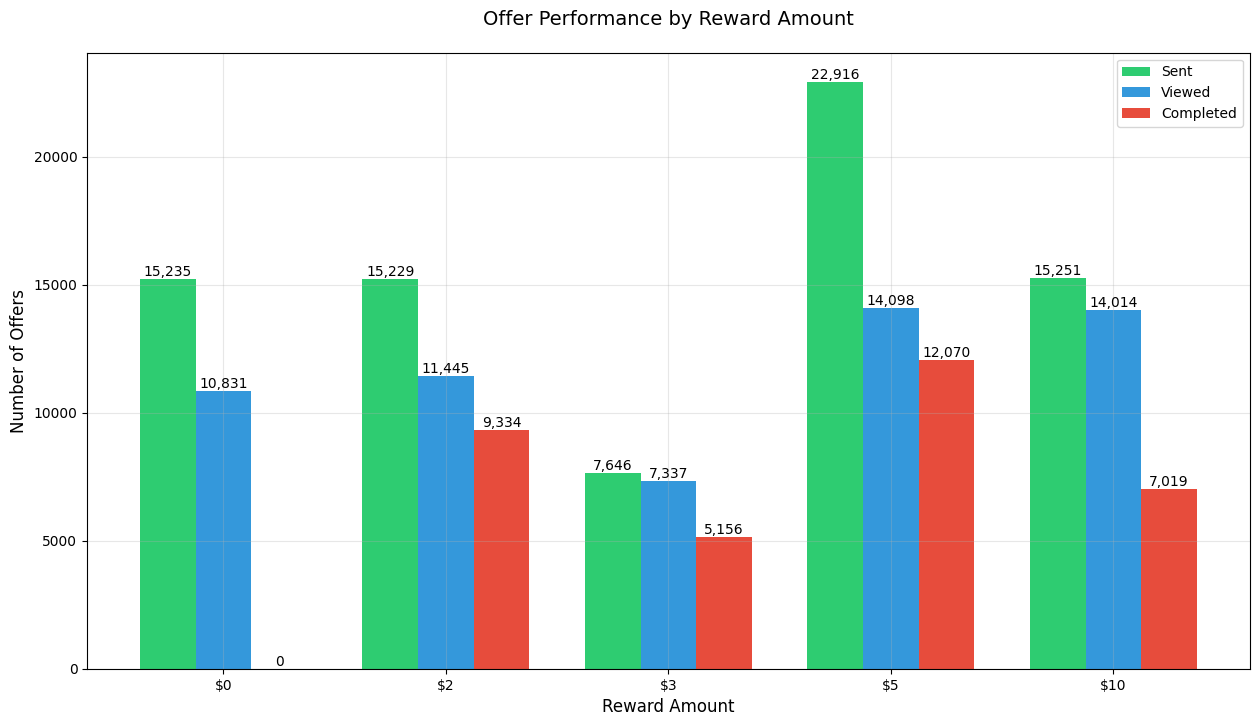

In [ ]:
# 3. Visualizations
if not reward_metrics.empty:
    # 3.1 Bar Chart - Absolute Numbers
    plt.figure(figsize=(15, 8))
    x = np.arange(len(reward_metrics.index))
    width = 0.25

    sent_bars = plt.bar(x - width, reward_metrics['Total Sent'], width,
                       label='Sent', color='#2ecc71')
    viewed_bars = plt.bar(x, reward_metrics['Total Viewed'], width,
                         label='Viewed', color='#3498db')
    completed_bars = plt.bar(x + width, reward_metrics['Total Completed'], width,
                            label='Completed', color='#e74c3c')

    plt.title('Offer Performance by Reward Amount', pad=20, fontsize=14)
    plt.xlabel('Reward Amount', fontsize=12)
    plt.ylabel('Number of Offers', fontsize=12)
    plt.xticks(x, reward_metrics.index)
    plt.legend()
    for i, bars in enumerate(zip(sent_bars, viewed_bars, completed_bars)):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=10)

    plt.grid(True, alpha=0.3)
    plt.show()

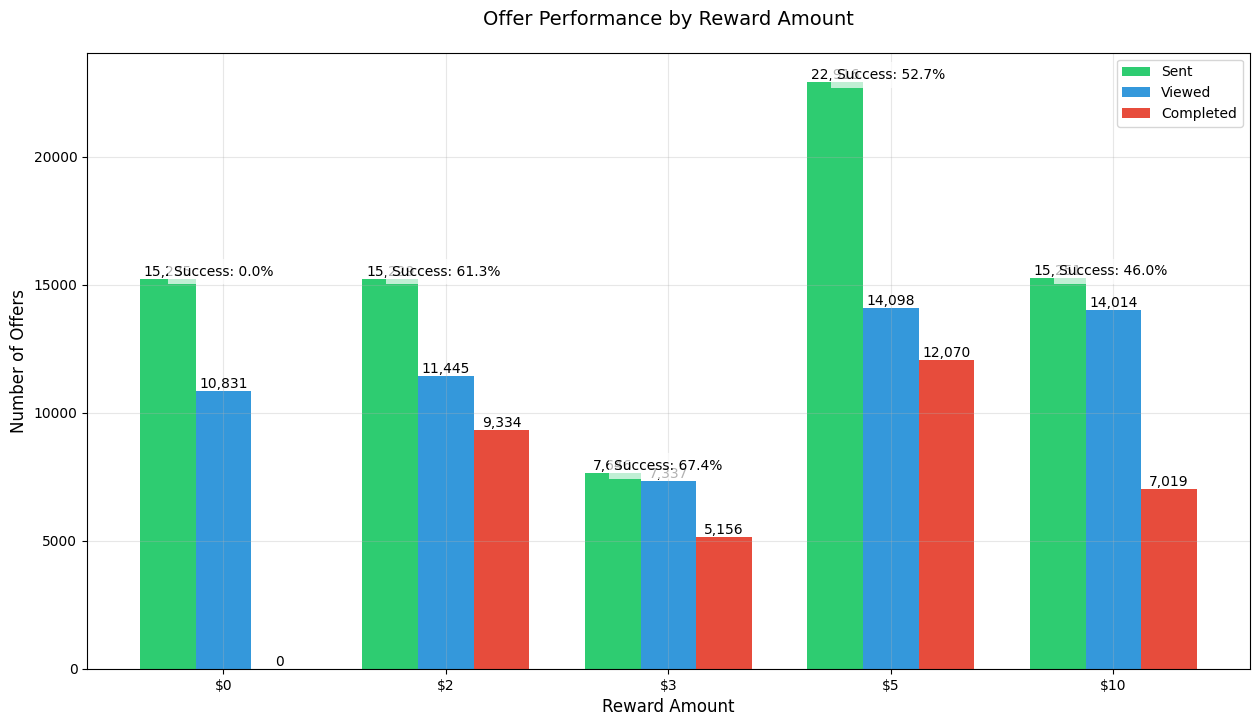

<Figure size 1200x600 with 0 Axes>

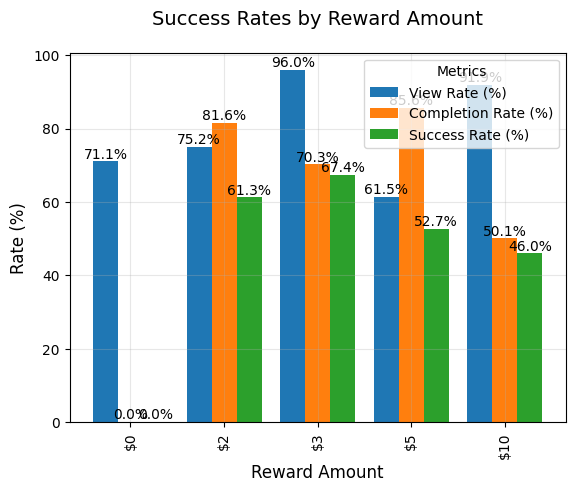

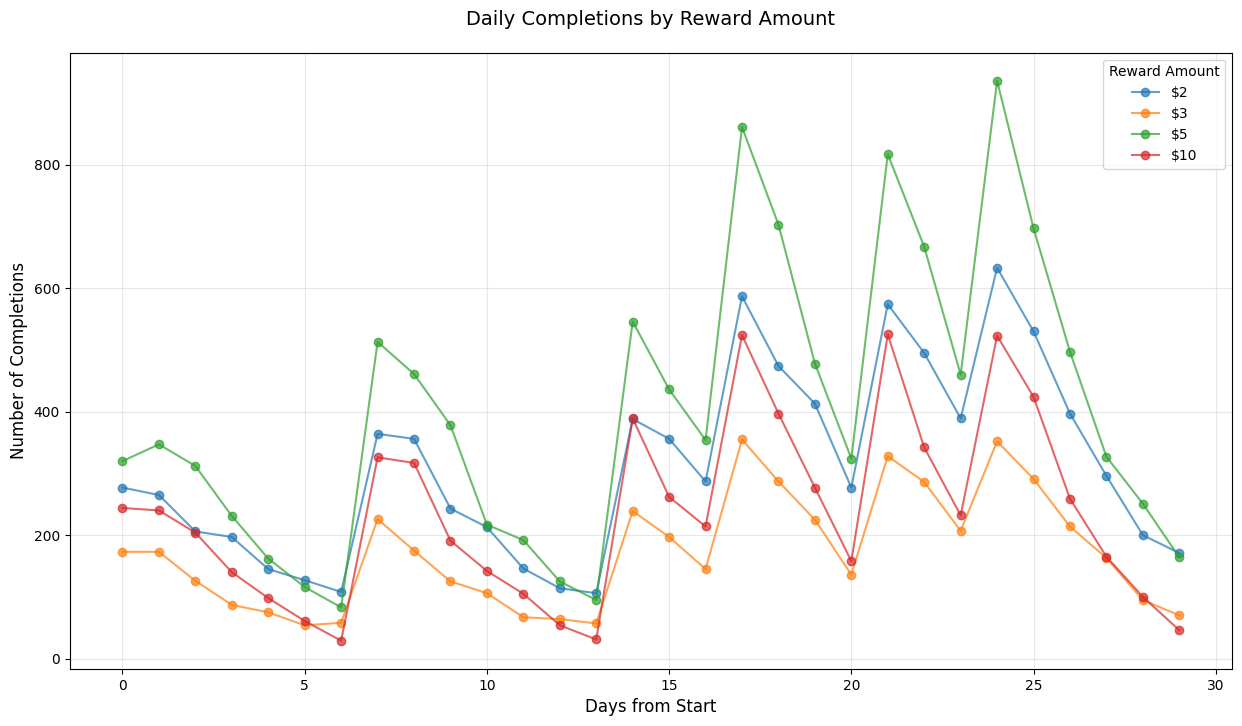

In [ ]:
# 3. Visualizations
if not reward_metrics.empty:
    # 3.1 Bar Chart - Absolute Numbers
    plt.figure(figsize=(15, 8))
    x = np.arange(len(reward_metrics.index))
    width = 0.25

    sent_bars = plt.bar(x - width, reward_metrics['Total Sent'], width,
                       label='Sent', color='#2ecc71')
    viewed_bars = plt.bar(x, reward_metrics['Total Viewed'], width,
                         label='Viewed', color='#3498db')
    completed_bars = plt.bar(x + width, reward_metrics['Total Completed'], width,
                            label='Completed', color='#e74c3c')

    plt.title('Offer Performance by Reward Amount', pad=20, fontsize=14)
    plt.xlabel('Reward Amount', fontsize=12)
    plt.ylabel('Number of Offers', fontsize=12)
    plt.xticks(x, reward_metrics.index)
    plt.legend()

    # Add value and success rate labels
    for i, bars in enumerate(zip(sent_bars, viewed_bars, completed_bars)):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=10)
        success_rate = reward_metrics['Success Rate (%)'].iloc[i]
        plt.text(x[i], max(b.get_height() for b in bars),
                f'Success: {success_rate:.1f}%',
                ha='center', va='bottom', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.grid(True, alpha=0.3)
    plt.show()

    # 3.2 Success Rates Comparison
    plt.figure(figsize=(12, 6))
    rates = reward_metrics[['View Rate (%)', 'Completion Rate (%)', 'Success Rate (%)']]
    ax = rates.plot(kind='bar', width=0.8)
    plt.title('Success Rates by Reward Amount', pad=20, fontsize=14)
    plt.xlabel('Reward Amount', fontsize=12)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.legend(title='Metrics')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

    plt.grid(True, alpha=0.3)
    plt.show()

    # 3.3 Time Trend Analysis
    completion_trend = pd.pivot_table(
        events_with_offers[events_with_offers['event'] == 'offer completed'],
        index='day',
        columns='reward_offer',
        values='event',
        aggfunc='count',
        fill_value=0
    )

    plt.figure(figsize=(15, 8))
    for reward in sorted(completion_trend.columns):
        plt.plot(completion_trend.index, completion_trend[reward],
                marker='o', label=f'${int(reward)}', alpha=0.7)

    plt.title('Daily Completions by Reward Amount', pad=20, fontsize=14)
    plt.xlabel('Days from Start', fontsize=12)
    plt.ylabel('Number of Completions', fontsize=12)
    plt.legend(title='Reward Amount')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# 4. ROI Analysis
roi_analysis = pd.DataFrame()
for reward in sorted(events_with_offers['reward_offer'].unique()):
    completed_offers = events_with_offers[
        (events_with_offers['reward_offer'] == reward) &
        (events_with_offers['event'] == 'offer completed')
    ]

    total_reward_cost = reward * len(completed_offers)
    reward_label = f"${int(reward)}"
    roi_analysis.loc[reward_label, 'Completions'] = len(completed_offers)
    roi_analysis.loc[reward_label, 'Total Cost'] = total_reward_cost
    roi_analysis.loc[reward_label, 'Cost per Completion'] = round(reward, 2)

    # Calculate revenue
    revenue_from_completions = completed_offers['amount'].sum()
    roi_analysis.loc[reward_label, 'Total Revenue'] = revenue_from_completions
    roi_analysis.loc[reward_label, 'Net Impact'] = revenue_from_completions - total_reward_cost
    roi_analysis.loc[reward_label, 'ROI (%)'] = round(
        (revenue_from_completions - total_reward_cost) / total_reward_cost * 100
        if total_reward_cost > 0 else 0, 2
    )

print("\nROI Analysis by Reward Level:")
print(roi_analysis)


ROI Analysis by Reward Level:
     Completions  Total Cost  Cost per Completion  Total Revenue  Net Impact  \
$0           0.0         0.0                  0.0            0.0         0.0   
$2        9334.0     18668.0                  2.0            0.0    -18668.0   
$3        5156.0     15468.0                  3.0            0.0    -15468.0   
$5       12070.0     60350.0                  5.0            0.0    -60350.0   
$10       7019.0     70190.0                 10.0            0.0    -70190.0   

     ROI (%)  
$0       0.0  
$2    -100.0  
$3    -100.0  
$5    -100.0  
$10   -100.0  


In [ ]:
print("\n=== Key Findings ===")
if not reward_metrics.empty:
    best_completion = reward_metrics['Completion Rate (%)'].idxmax()
    best_success = reward_metrics['Success Rate (%)'].idxmax()
    best_roi = roi_analysis['ROI (%)'].idxmax() if 'ROI (%)' in roi_analysis.columns else None

    print(f"\nBest Completion Rate: {best_completion} ({reward_metrics.loc[best_completion, 'Completion Rate (%)']}%)")
    print(f"Best Overall Success Rate: {best_success} ({reward_metrics.loc[best_success, 'Success Rate (%)']}%)")
    if best_roi:
        print(f"Best ROI: {best_roi} ({roi_analysis.loc[best_roi, 'ROI (%)']}%)")


=== Key Findings ===

Best Completion Rate: $5 (85.61%)
Best Overall Success Rate: $3 (67.43%)
Best ROI: $0 (0.0%)


In [ ]:
#################### PART 1: DURATION EFFECTIVENESS ####################
print("=== ANALYZING DURATION EFFECTIVENESS ===")

# 1. Merge data để có duration info
duration_performance = pd.merge(
    events_processed[events_processed['valid_completion'] == True],
    offers[['offer_id', 'duration', 'offer_type']],
    on='offer_id',
    how='inner',
    suffixes=('_event', '_offer')
)
print("\nDuration values available:")
print(sorted(duration_performance['duration'].unique()))


=== ANALYZING DURATION EFFECTIVENESS ===

Duration values available:
[3, 4, 5, 7, 10]


In [ ]:
# 2. Calculate metrics by duration
duration_metrics = pd.DataFrame()

for duration in sorted(duration_performance['duration'].unique()):
    duration_data = duration_performance[duration_performance['duration'] == duration]
    received = duration_data[duration_data['event'] == 'offer received'].shape[0]
    viewed = duration_data[duration_data['event'] == 'offer viewed'].shape[0]
    completed = duration_data[duration_data['event'] == 'offer completed'].shape[0]

    if received > 0:
        duration_label = f"{int(duration)} days"
        duration_metrics.loc[duration_label, 'Total Sent'] = received
        duration_metrics.loc[duration_label, 'Total Viewed'] = viewed
        duration_metrics.loc[duration_label, 'Total Completed'] = completed
        duration_metrics.loc[duration_label, 'View Rate (%)'] = round((viewed/received)*100, 2)
        duration_metrics.loc[duration_label, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        duration_metrics.loc[duration_label, 'Success Rate (%)'] = round((completed/received)*100, 2)
        if completed > 0:
            completion_times = duration_data[duration_data['event'] == 'offer completed']['day'] - \
                             duration_data[duration_data['event'] == 'offer received']['day'].iloc[0]
            duration_metrics.loc[duration_label, 'Avg Days to Complete'] = round(completion_times.mean(), 1)

print("\nDuration Performance Metrics:")
print(duration_metrics)


Duration Performance Metrics:
         Total Sent  Total Viewed  Total Completed  View Rate (%)  \
3 days       7618.0        6687.0              0.0          87.78   
4 days       7617.0        4144.0              0.0          54.40   
5 days      15164.0       14562.0           7627.0          96.03   
7 days      30613.0       22342.0          17215.0          72.98   
10 days     15265.0        9990.0           8737.0          65.44   

         Completion Rate (%)  Success Rate (%)  Avg Days to Complete  
3 days                  0.00              0.00                   NaN  
4 days                  0.00              0.00                   NaN  
5 days                 52.38             50.30                  15.7  
7 days                 77.05             56.23                  16.4  
10 days                87.46             57.24                  16.8  


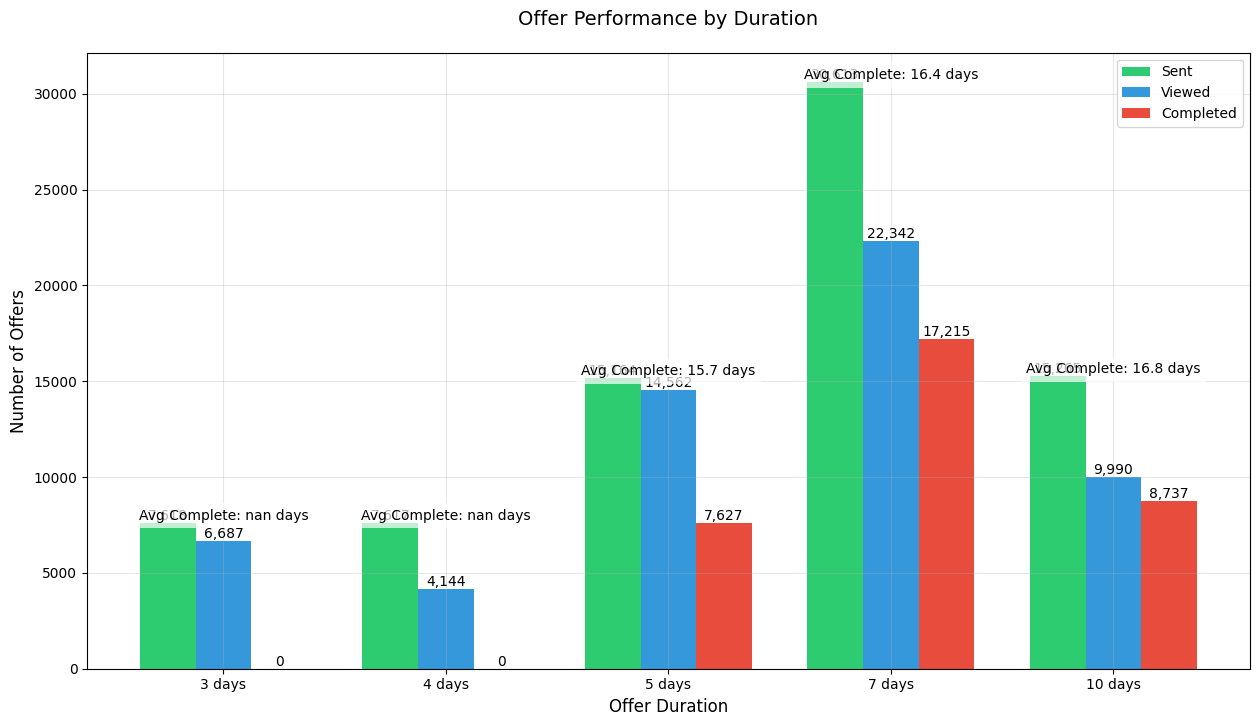

<Figure size 1200x600 with 0 Axes>

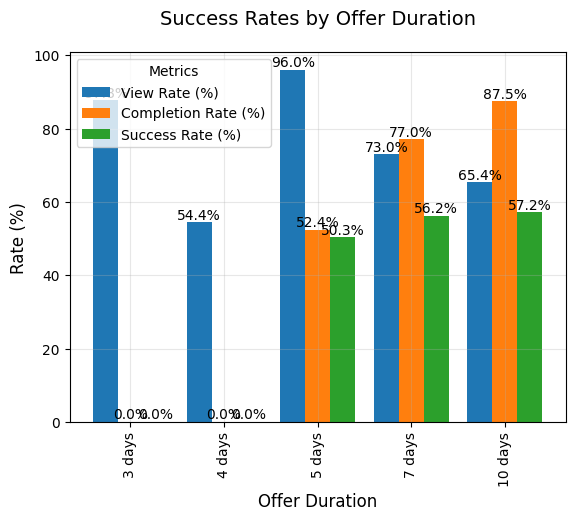

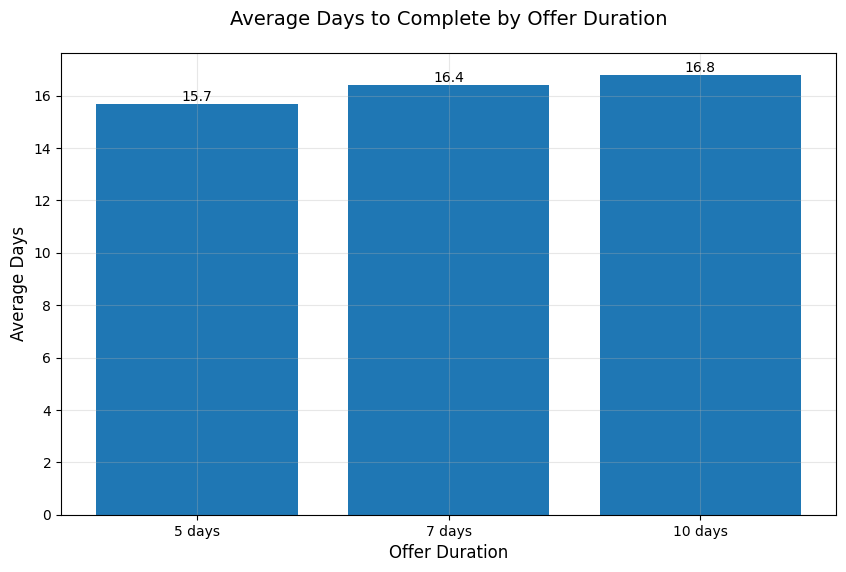

In [ ]:
# 3. Visualizations
if not duration_metrics.empty:
    # 3.1 Bar Chart - Absolute Numbers
    plt.figure(figsize=(15, 8))
    x = np.arange(len(duration_metrics.index))
    width = 0.25

    sent_bars = plt.bar(x - width, duration_metrics['Total Sent'], width,
                       label='Sent', color='#2ecc71')
    viewed_bars = plt.bar(x, duration_metrics['Total Viewed'], width,
                         label='Viewed', color='#3498db')
    completed_bars = plt.bar(x + width, duration_metrics['Total Completed'], width,
                            label='Completed', color='#e74c3c')

    plt.title('Offer Performance by Duration', pad=20, fontsize=14)
    plt.xlabel('Offer Duration', fontsize=12)
    plt.ylabel('Number of Offers', fontsize=12)
    plt.xticks(x, duration_metrics.index)
    plt.legend()
    for i, bars in enumerate(zip(sent_bars, viewed_bars, completed_bars)):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=10)

        if 'Avg Days to Complete' in duration_metrics.columns:
            avg_days = duration_metrics['Avg Days to Complete'].iloc[i]
            plt.text(x[i], max(b.get_height() for b in bars),
                    f'Avg Complete: {avg_days:.1f} days',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.grid(True, alpha=0.3)
    plt.show()

    # 3.2 Success Rates by Duration
    plt.figure(figsize=(12, 6))
    rates = duration_metrics[['View Rate (%)', 'Completion Rate (%)', 'Success Rate (%)']]
    ax = rates.plot(kind='bar', width=0.8)
    plt.title('Success Rates by Offer Duration', pad=20, fontsize=14)
    plt.xlabel('Offer Duration', fontsize=12)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.legend(title='Metrics')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

    plt.grid(True, alpha=0.3)
    plt.show()

    # 3.3 Completion Time Analysis
    if 'Avg Days to Complete' in duration_metrics.columns:
        plt.figure(figsize=(10, 6))
        plt.bar(duration_metrics.index, duration_metrics['Avg Days to Complete'])
        plt.title('Average Days to Complete by Offer Duration', pad=20, fontsize=14)
        plt.xlabel('Offer Duration', fontsize=12)
        plt.ylabel('Average Days', fontsize=12)
        for i, v in enumerate(duration_metrics['Avg Days to Complete']):
            plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

        plt.grid(True, alpha=0.3)
        plt.show()

In [ ]:
#################### PART 2: CHANNEL EFFECTIVENESS ####################
print("\n=== ANALYZING CHANNEL EFFECTIVENESS ===")
def extract_channels(channel_str):
    try:
        # Convert string representation of list to actual list
        channels = eval(channel_str) if isinstance(channel_str, str) else channel_str
        return channels
    except:
        return []

# Get all unique channels
all_channels = set()
for channels in offers['channels']:
    channel_list = extract_channels(channels)
    all_channels.update(channel_list)

print("\nAvailable channels:", sorted(all_channels))


=== ANALYZING CHANNEL EFFECTIVENESS ===

Available channels: ['email', 'mobile', 'social', 'web']


In [ ]:
# 2. Create metrics for each channel
channel_metrics = pd.DataFrame()

for channel in sorted(all_channels):
    channel_offers = offers[offers['channels'].apply(
        lambda x: channel in extract_channels(x)
    )]['offer_id'].unique()

    channel_data = duration_performance[
        duration_performance['offer_id'].isin(channel_offers)
    ]
    received = channel_data[channel_data['event'] == 'offer received'].shape[0]
    viewed = channel_data[channel_data['event'] == 'offer viewed'].shape[0]
    completed = channel_data[channel_data['event'] == 'offer completed'].shape[0]

    if received > 0:
        channel_metrics.loc[channel, 'Total Sent'] = received
        channel_metrics.loc[channel, 'Total Viewed'] = viewed
        channel_metrics.loc[channel, 'Total Completed'] = completed
        channel_metrics.loc[channel, 'View Rate (%)'] = round((viewed/received)*100, 2)
        channel_metrics.loc[channel, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        channel_metrics.loc[channel, 'Success Rate (%)'] = round((completed/received)*100, 2)

print("\nChannel Performance Metrics:")
print(channel_metrics)


Channel Performance Metrics:
        Total Sent  Total Viewed  Total Completed  View Rate (%)  \
email      76277.0       57725.0          33579.0          75.68   
mobile     68609.0       55062.0          30159.0          80.25   
social     45683.0       42629.0          21788.0          93.31   
web        61001.0       44322.0          29891.0          72.66   

        Completion Rate (%)  Success Rate (%)  
email                 58.17             44.02  
mobile                54.77             43.96  
social                51.11             47.69  
web                   67.44             49.00  


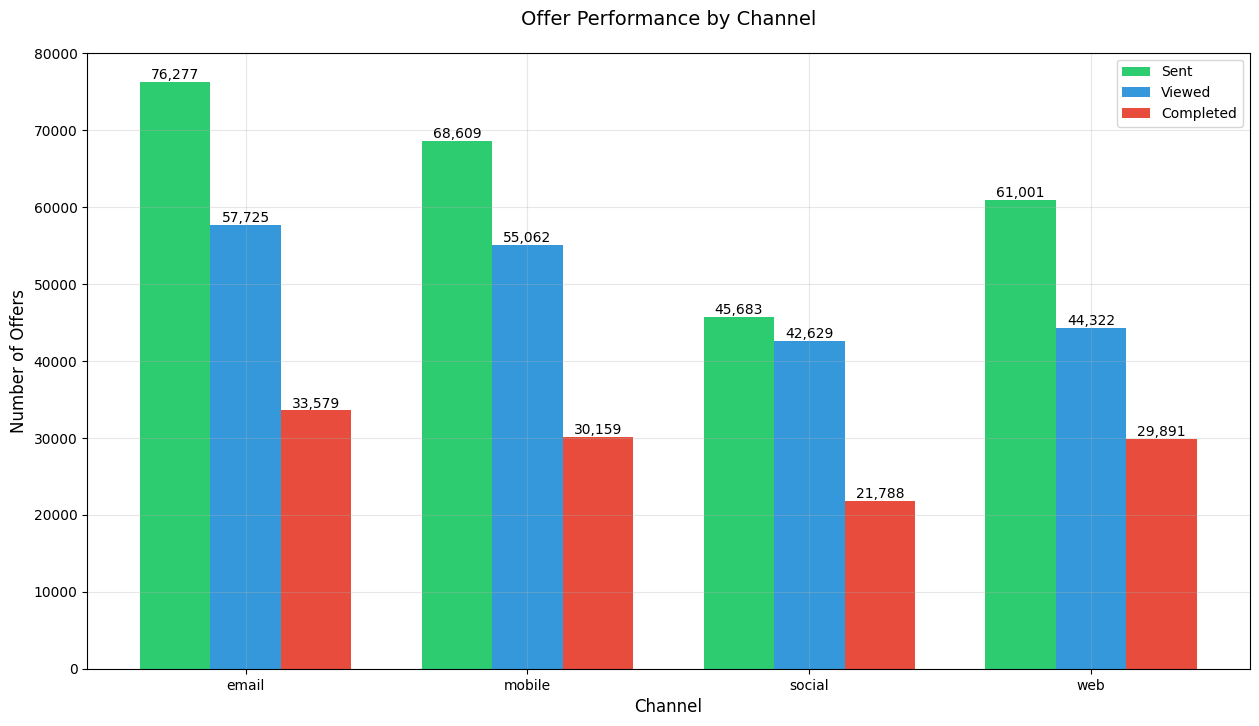

<Figure size 1200x600 with 0 Axes>

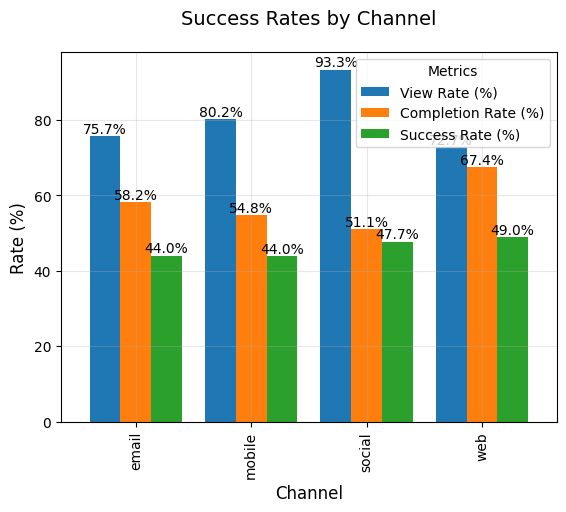

In [ ]:
# 3. Visualizations for Channel Analysis
if not channel_metrics.empty:
    # 3.1 Bar Chart - Channel Performance
    plt.figure(figsize=(15, 8))
    x = np.arange(len(channel_metrics.index))
    width = 0.25

    sent_bars = plt.bar(x - width, channel_metrics['Total Sent'], width,
                       label='Sent', color='#2ecc71')
    viewed_bars = plt.bar(x, channel_metrics['Total Viewed'], width,
                         label='Viewed', color='#3498db')
    completed_bars = plt.bar(x + width, channel_metrics['Total Completed'], width,
                            label='Completed', color='#e74c3c')

    plt.title('Offer Performance by Channel', pad=20, fontsize=14)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Number of Offers', fontsize=12)
    plt.xticks(x, channel_metrics.index)
    plt.legend()
    for bars in [sent_bars, viewed_bars, completed_bars]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.show()

    # 3.2 Channel Success Rates
    plt.figure(figsize=(12, 6))
    rates = channel_metrics[['View Rate (%)', 'Completion Rate (%)', 'Success Rate (%)']]
    ax = rates.plot(kind='bar', width=0.8)
    plt.title('Success Rates by Channel', pad=20, fontsize=14)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.legend(title='Metrics')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
print("\n=== Key Findings ===")
print("\nDuration Effectiveness:")
best_duration_completion = duration_metrics['Completion Rate (%)'].idxmax()
best_duration_success = duration_metrics['Success Rate (%)'].idxmax()
print(f"Best Completion Rate: {best_duration_completion} ({duration_metrics.loc[best_duration_completion, 'Completion Rate (%)']}%)")
print(f"Best Success Rate: {best_duration_success} ({duration_metrics.loc[best_duration_success, 'Success Rate (%)']}%)")
if 'Avg Days to Complete' in duration_metrics.columns:
    fastest_duration = duration_metrics['Avg Days to Complete'].idxmin()
    print(f"Fastest Completion: {fastest_duration} ({duration_metrics.loc[fastest_duration, 'Avg Days to Complete']:.1f} days)")

print("\nChannel Effectiveness:")
best_channel_view = channel_metrics['View Rate (%)'].idxmax()
best_channel_completion = channel_metrics['Completion Rate (%)'].idxmax()
print(f"Best View Rate: {best_channel_view} ({channel_metrics.loc[best_channel_view, 'View Rate (%)']}%)")
print(f"Best Completion Rate: {best_channel_completion} ({channel_metrics.loc[best_channel_completion, 'Completion Rate (%)']}%)")


=== Key Findings ===

Duration Effectiveness:
Best Completion Rate: 10 days (87.46%)
Best Success Rate: 10 days (57.24%)
Fastest Completion: 5 days (15.7 days)

Channel Effectiveness:
Best View Rate: social (93.31%)
Best Completion Rate: web (67.44%)


In [ ]:
print("=== ANALYZING DEMOGRAPHIC SEGMENTATION ===")

# 1. Merge customer demographics với offer performance
demographic_analysis = pd.merge(
    events_processed[events_processed['valid_completion'] == True],
    customers_processed[['customer_id', 'age', 'income', 'gender']],
    on='customer_id',
    how='inner'
)

demographic_analysis = pd.merge(
    demographic_analysis,
    offers[['offer_id', 'offer_type', 'reward', 'difficulty']],
    on='offer_id',
    how='inner'
)

=== ANALYZING DEMOGRAPHIC SEGMENTATION ===


In [ ]:
# 2. Age Segmentation
print("\n=== Age Segmentation ===")
# Create age bins
bins = [0, 25, 35, 45, 55, 65, np.inf]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
demographic_analysis['age_group'] = pd.cut(demographic_analysis['age'], bins=bins, labels=labels)

# Calculate metrics by age group
age_metrics = pd.DataFrame()
for age_group in labels:
    age_data = demographic_analysis[demographic_analysis['age_group'] == age_group]

    received = age_data[age_data['event'] == 'offer received'].shape[0]
    viewed = age_data[age_data['event'] == 'offer viewed'].shape[0]
    completed = age_data[age_data['event'] == 'offer completed'].shape[0]

    if received > 0:
        age_metrics.loc[age_group, 'Total Sent'] = received
        age_metrics.loc[age_group, 'Total Viewed'] = viewed
        age_metrics.loc[age_group, 'Total Completed'] = completed
        age_metrics.loc[age_group, 'View Rate (%)'] = round((viewed/received)*100, 2)
        age_metrics.loc[age_group, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        age_metrics.loc[age_group, 'Success Rate (%)'] = round((completed/received)*100, 2)
        # Average spending
        completed_amount = age_data[age_data['event'] == 'offer completed']['amount'].mean()
        age_metrics.loc[age_group, 'Avg Spend'] = round(completed_amount if not pd.isna(completed_amount) else 0, 2)

print("\nAge Group Performance Metrics:")
print(age_metrics)


=== Age Segmentation ===

Age Group Performance Metrics:
       Total Sent  Total Viewed  Total Completed  View Rate (%)  \
18-25      4543.0        3140.0           1704.0          69.12   
26-35      6193.0        4288.0           2492.0          69.24   
36-45      8828.0        6917.0           4131.0          78.35   
46-55     21630.0       16830.0           7926.0          77.81   
56-65     17332.0       13190.0           8167.0          76.10   
65+       17751.0       13360.0           9159.0          75.26   

       Completion Rate (%)  Success Rate (%)  Avg Spend  
18-25                54.27             37.51        0.0  
26-35                58.12             40.24        0.0  
36-45                59.72             46.79        0.0  
46-55                47.09             36.64        0.0  
56-65                61.92             47.12        0.0  
65+                  68.56             51.60        0.0  


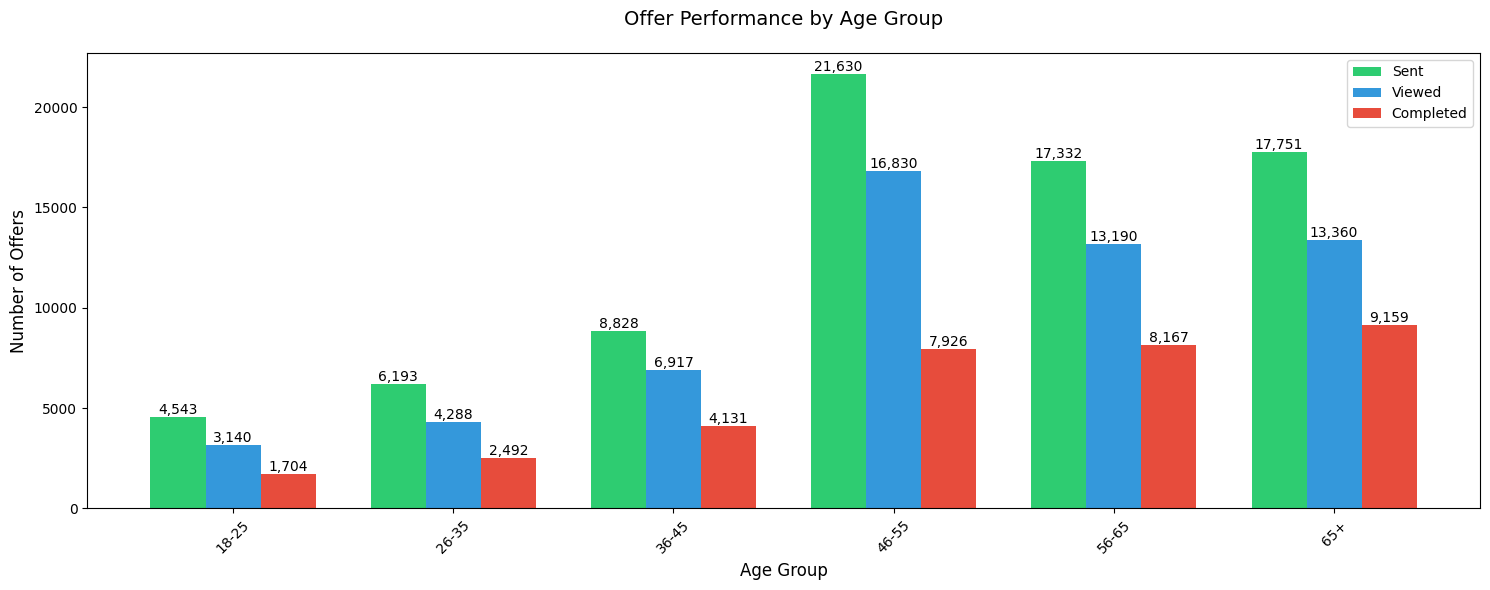

<Figure size 1200x600 with 0 Axes>

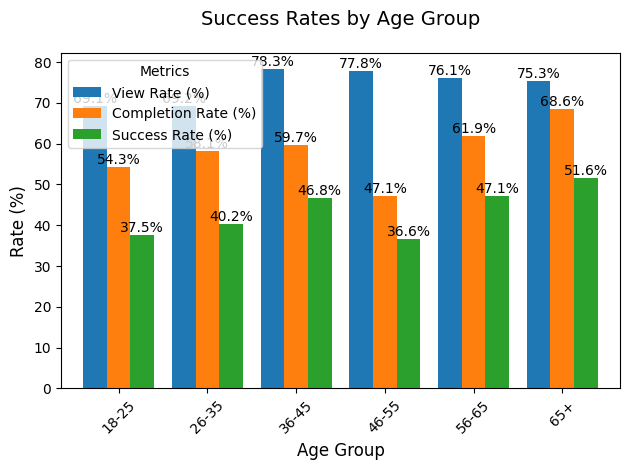

In [ ]:
# Visualize age group performance
plt.figure(figsize=(15, 6))
x = np.arange(len(age_metrics.index))
width = 0.25

sent_bars = plt.bar(x - width, age_metrics['Total Sent'], width, label='Sent', color='#2ecc71')
viewed_bars = plt.bar(x, age_metrics['Total Viewed'], width, label='Viewed', color='#3498db')
completed_bars = plt.bar(x + width, age_metrics['Total Completed'], width, label='Completed', color='#e74c3c')

plt.title('Offer Performance by Age Group', pad=20, fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Offers', fontsize=12)
plt.xticks(x, age_metrics.index, rotation=45)
plt.legend()
for bars in [sent_bars, viewed_bars, completed_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Success rates by age group
plt.figure(figsize=(12, 6))
rates = age_metrics[['View Rate (%)', 'Completion Rate (%)', 'Success Rate (%)']]
ax = rates.plot(kind='bar', width=0.8)
plt.title('Success Rates by Age Group', pad=20, fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)
plt.legend(title='Metrics')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [ ]:
# 3. Income Segmentation
print("\n=== Income Segmentation ===")
# Create income bins (in thousands)
income_bins = [0, 40000, 60000, 80000, 100000, np.inf]
income_labels = ['<40k', '40k-60k', '60k-80k', '80k-100k', '100k+']
demographic_analysis['income_group'] = pd.cut(demographic_analysis['income'],
                                            bins=income_bins,
                                            labels=income_labels)

# Calculate metrics by income group
income_metrics = pd.DataFrame()
for income_group in income_labels:
    income_data = demographic_analysis[demographic_analysis['income_group'] == income_group]

    received = income_data[income_data['event'] == 'offer received'].shape[0]
    viewed = income_data[income_data['event'] == 'offer viewed'].shape[0]
    completed = income_data[income_data['event'] == 'offer completed'].shape[0]

    if received > 0:
        income_metrics.loc[income_group, 'Total Sent'] = received
        income_metrics.loc[income_group, 'Total Viewed'] = viewed
        income_metrics.loc[income_group, 'Total Completed'] = completed
        income_metrics.loc[income_group, 'View Rate (%)'] = round((viewed/received)*100, 2)
        income_metrics.loc[income_group, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        income_metrics.loc[income_group, 'Success Rate (%)'] = round((completed/received)*100, 2)
        # Average spending
        completed_amount = income_data[income_data['event'] == 'offer completed']['amount'].mean()
        income_metrics.loc[income_group, 'Avg Spend'] = round(completed_amount if not pd.isna(completed_amount) else 0, 2)

print("\nIncome Group Performance Metrics:")
print(income_metrics)


=== Income Segmentation ===

Income Group Performance Metrics:
          Total Sent  Total Viewed  Total Completed  View Rate (%)  \
<40k          9667.0        6625.0           3378.0          68.53   
40k-60k      21404.0       16009.0           8813.0          74.79   
60k-80k      29241.0       22932.0          11587.0          78.42   
80k-100k     11439.0        9162.0           6978.0          80.09   
100k+         4526.0        2997.0           2823.0          66.22   

          Completion Rate (%)  Success Rate (%)  Avg Spend  
<40k                    50.99             34.94        0.0  
40k-60k                 55.05             41.17        0.0  
60k-80k                 50.53             39.63        0.0  
80k-100k                76.16             61.00        0.0  
100k+                   94.19             62.37        0.0  


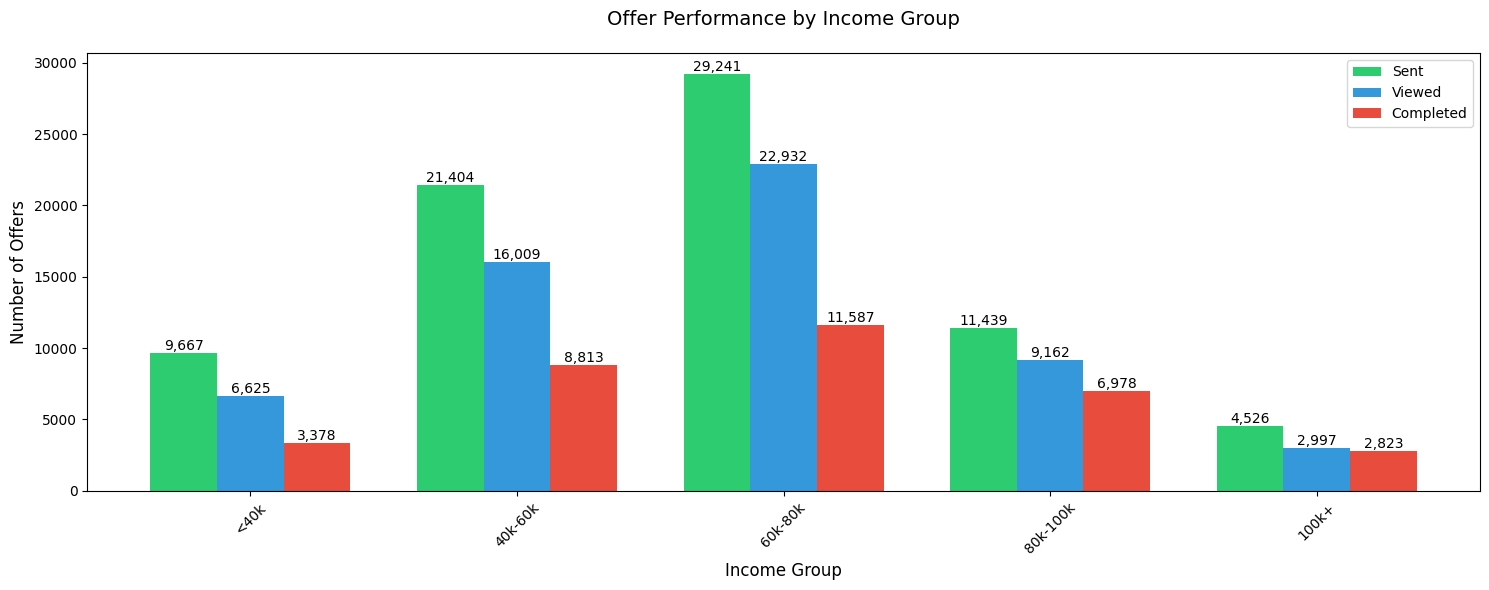

In [ ]:
# Visualize income group performance
plt.figure(figsize=(15, 6))
x = np.arange(len(income_metrics.index))
width = 0.25

sent_bars = plt.bar(x - width, income_metrics['Total Sent'], width, label='Sent', color='#2ecc71')
viewed_bars = plt.bar(x, income_metrics['Total Viewed'], width, label='Viewed', color='#3498db')
completed_bars = plt.bar(x + width, income_metrics['Total Completed'], width, label='Completed', color='#e74c3c')

plt.title('Offer Performance by Income Group', pad=20, fontsize=14)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Number of Offers', fontsize=12)
plt.xticks(x, income_metrics.index, rotation=45)
plt.legend()

for bars in [sent_bars, viewed_bars, completed_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# 4. Gender Analysis
print("\n=== Gender Analysis ===")
gender_metrics = pd.DataFrame()

for gender in demographic_analysis['gender'].unique():
    gender_data = demographic_analysis[demographic_analysis['gender'] == gender]

    received = gender_data[gender_data['event'] == 'offer received'].shape[0]
    viewed = gender_data[gender_data['event'] == 'offer viewed'].shape[0]
    completed = gender_data[gender_data['event'] == 'offer completed'].shape[0]

    if received > 0:
        gender_metrics.loc[gender, 'Total Sent'] = received
        gender_metrics.loc[gender, 'Total Viewed'] = viewed
        gender_metrics.loc[gender, 'Total Completed'] = completed
        gender_metrics.loc[gender, 'View Rate (%)'] = round((viewed/received)*100, 2)
        gender_metrics.loc[gender, 'Completion Rate (%)'] = round((completed/viewed)*100, 2) if viewed > 0 else 0
        gender_metrics.loc[gender, 'Success Rate (%)'] = round((completed/received)*100, 2)
        # Average spending
        completed_amount = gender_data[gender_data['event'] == 'offer completed']['amount'].mean()
        gender_metrics.loc[gender, 'Avg Spend'] = round(completed_amount if not pd.isna(completed_amount) else 0, 2)

print("\nGender Performance Metrics:")
print(gender_metrics)


=== Gender Analysis ===

Gender Performance Metrics:
   Total Sent  Total Viewed  Total Completed  View Rate (%)  \
F     31527.0       24090.0          15960.0          76.41   
M     43670.0       32723.0          17093.0          74.93   
O      1080.0         912.0            526.0          84.44   

   Completion Rate (%)  Success Rate (%)  Avg Spend  
F                66.25             50.62        0.0  
M                52.24             39.14        0.0  
O                57.68             48.70        0.0  


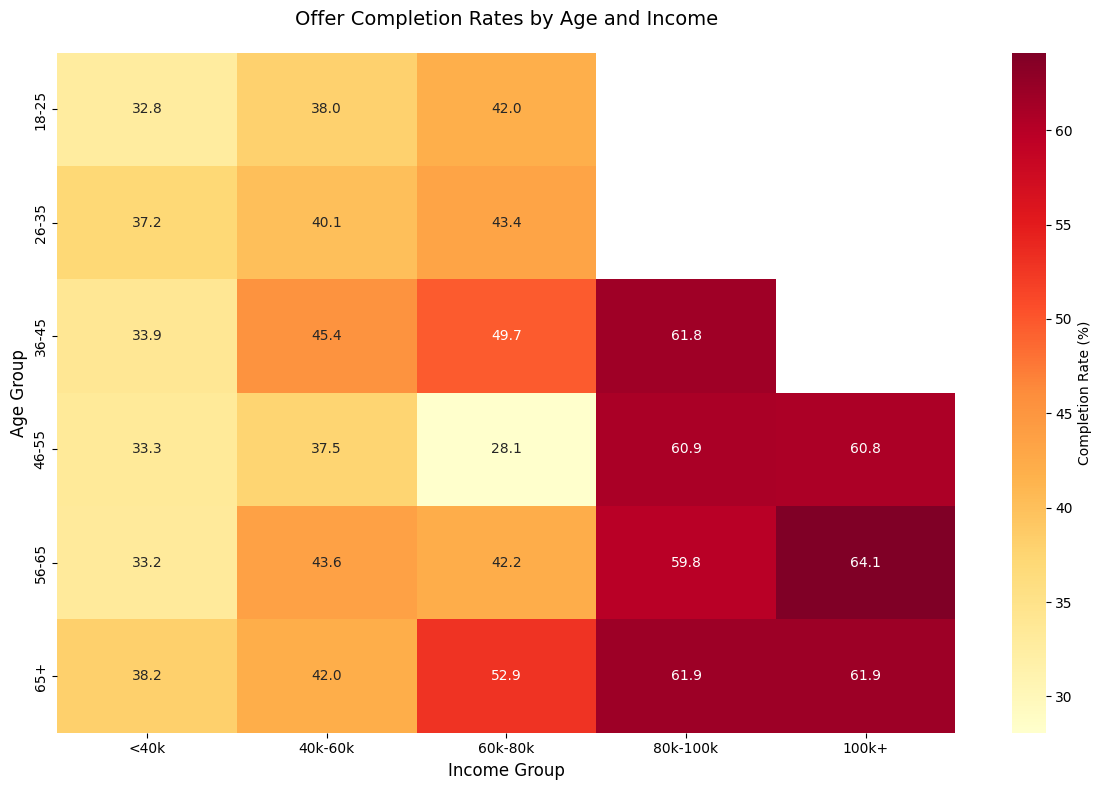

In [ ]:
# 5. Cross-Segment Analysis
# Create heatmap of completion rates
plt.figure(figsize=(12, 8))
completion_matrix = pd.pivot_table(
    demographic_analysis[demographic_analysis['event'] == 'offer completed'],
    values='event',
    index='age_group',
    columns='income_group',
    aggfunc='count',
    fill_value=0
)

# Normalize by total offers in each segment
total_offers_matrix = pd.pivot_table(
    demographic_analysis[demographic_analysis['event'] == 'offer received'],
    values='event',
    index='age_group',
    columns='income_group',
    aggfunc='count',
    fill_value=0
)

completion_rates = (completion_matrix / total_offers_matrix * 100).round(2)

sns.heatmap(completion_rates, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Completion Rate (%)'})
plt.title('Offer Completion Rates by Age and Income', pad=20, fontsize=14)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Age Group', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# 6. Segment Preferences
# Analyze offer type preferences by segment
offer_preferences = pd.pivot_table(
    demographic_analysis[demographic_analysis['event'] == 'offer completed'],
    values='event',
    index=['age_group', 'income_group'],
    columns='offer_type',
    aggfunc='count',
    fill_value=0
)

# Calculate percentage preferences
offer_preferences_pct = offer_preferences.div(offer_preferences.sum(axis=1), axis=0) * 100

print("\nOffer Type Preferences by Segment:")
print(offer_preferences_pct.round(2))



Offer Type Preferences by Segment:
offer_type               bogo  discount
age_group income_group                 
18-25     <40k          42.69     57.31
          40k-60k       43.64     56.36
          60k-80k       44.56     55.44
          80k-100k        NaN       NaN
          100k+           NaN       NaN
26-35     <40k          45.35     54.65
          40k-60k       44.22     55.78
          60k-80k       47.02     52.98
          80k-100k        NaN       NaN
          100k+           NaN       NaN
36-45     <40k          45.40     54.60
          40k-60k       46.62     53.38
          60k-80k       46.83     53.17
          80k-100k      49.24     50.76
          100k+           NaN       NaN
46-55     <40k          46.25     53.75
          40k-60k       45.10     54.90
          60k-80k       44.69     55.31
          80k-100k      50.93     49.07
          100k+         49.77     50.23
56-65     <40k          41.42     58.58
          40k-60k       46.96     53.04
    

In [ ]:
# 7. Print Key Findings
print("\n=== Key Demographic Insights ===")
print("\nBest Performing Age Groups:")
print(f"Highest View Rate: {age_metrics['View Rate (%)'].idxmax()} ({age_metrics['View Rate (%)'].max():.1f}%)")
print(f"Highest Completion Rate: {age_metrics['Completion Rate (%)'].idxmax()} ({age_metrics['Completion Rate (%)'].max():.1f}%)")
print(f"Highest Average Spend: {age_metrics['Avg Spend'].idxmax()} (${age_metrics['Avg Spend'].max():.2f})")

print("\nBest Performing Income Groups:")
print(f"Highest View Rate: {income_metrics['View Rate (%)'].idxmax()} ({income_metrics['View Rate (%)'].max():.1f}%)")
print(f"Highest Completion Rate: {income_metrics['Completion Rate (%)'].idxmax()} ({income_metrics['Completion Rate (%)'].max():.1f}%)")
print(f"Highest Average Spend: {income_metrics['Avg Spend'].idxmax()} (${income_metrics['Avg Spend'].max():.2f})")

print("\nGender Performance:")
print(f"Highest View Rate: {gender_metrics['View Rate (%)'].idxmax()} ({gender_metrics['View Rate (%)'].max():.1f}%)")
print(f"Highest Completion Rate: {gender_metrics['Completion Rate (%)'].idxmax()} ({gender_metrics['Completion Rate (%)'].max():.1f}%)")
print(f"Highest Average Spend: {gender_metrics['Avg Spend'].idxmax()} (${gender_metrics['Avg Spend'].max():.2f})")



=== Key Demographic Insights ===

Best Performing Age Groups:
Highest View Rate: 36-45 (78.3%)
Highest Completion Rate: 65+ (68.6%)
Highest Average Spend: 18-25 ($0.00)

Best Performing Income Groups:
Highest View Rate: 80k-100k (80.1%)
Highest Completion Rate: 100k+ (94.2%)
Highest Average Spend: <40k ($0.00)

Gender Performance:
Highest View Rate: O (84.4%)
Highest Completion Rate: F (66.2%)
Highest Average Spend: F ($0.00)


In [ ]:
# 1. Create age and income bins
print("=== Creating Customer Segments ===")

# Define age groups
age_bins = [18, 24, 34, 44, 54, 64, np.inf]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
age_group_names = ['Young Adults', 'Early Career', 'Young Families',
                   'Mature Professionals', 'Pre-Retirement', 'Retirees']

# Define income groups (in thousands)
income_bins = [30000, 50000, 75000, 100000, 120000]
income_labels = ['30k-50k', '50k-75k', '75k-100k', '100k-120k']
income_group_names = ['Lower-Middle', 'Middle', 'Upper-Middle', 'Affluent']

=== Creating Customer Segments ===


In [ ]:
# Create DataFrame for clustering
print("\nPreparing data for clustering...")

# Calculate customer purchase metrics
customer_metrics = events_processed[
    events_processed['event'] == 'transaction'
].groupby('customer_id').agg({
    'amount': ['sum', 'count']
}).reset_index()

customer_metrics.columns = ['customer_id', 'Amount_Purchased', 'No_of_Transactions']

# Merge with customer demographics
df_clustering = pd.merge(
    customers_processed[['customer_id', 'age', 'income']],
    customer_metrics,
    on='customer_id',
    how='left'
)

# Fill NaN values with 0 for customers with no transactions
df_clustering.fillna(0, inplace=True)

print("\nClustering data shape:", df_clustering.shape)
print("\nFeatures for clustering:")
print(df_clustering.columns.tolist())


Preparing data for clustering...

Clustering data shape: (17000, 5)

Features for clustering:
['customer_id', 'age', 'income', 'Amount_Purchased', 'No_of_Transactions']


In [ ]:
# 2. Implement K-Means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Prepare features for clustering
features = ['age', 'income', 'Amount_Purchased', 'No_of_Transactions']
X = df_clustering[features]


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Finding optimal number of clusters...


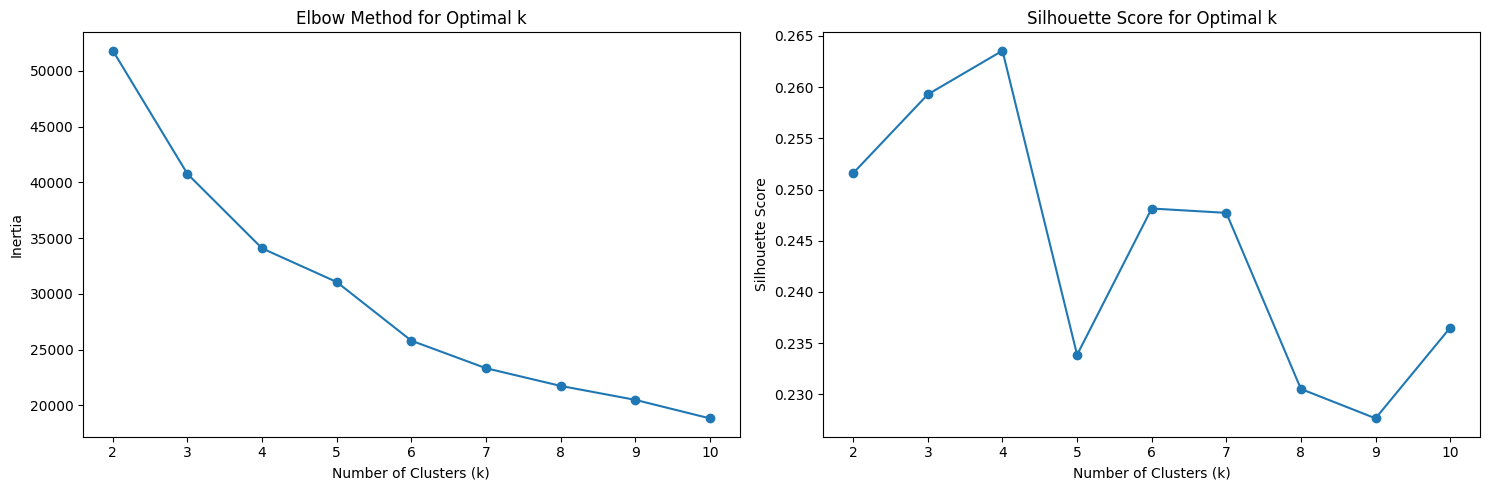

In [ ]:
# Find optimal number of clusters
print("\nFinding optimal number of clusters...")
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(15, 5))

# Elbow method plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

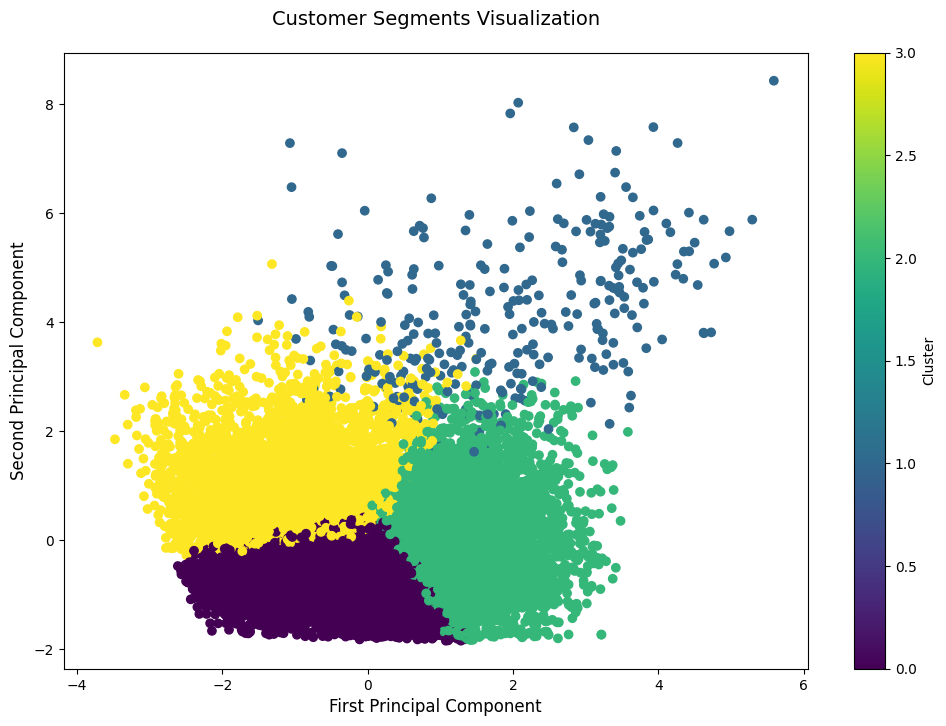

In [ ]:
# Apply K-Means with optimal k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clustering['Cluster'] = kmeans.fit_predict(X_scaled)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clustering['PCA1'] = X_pca[:, 0]
df_clustering['PCA2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clustering['PCA1'], df_clustering['PCA2'],
                     c=df_clustering['Cluster'], cmap='viridis')
plt.title('Customer Segments Visualization', pad=20, fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
print("=== Verifying Clustering Data ===")
print("\nColumns in df_clustering:")
print(df_clustering.columns.tolist())

# Add age and income groups if not present
df_clustering['Age_Group'] = pd.cut(
    df_clustering['age'],
    bins=[18, 24, 34, 44, 54, 64, np.inf],
    labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)

df_clustering['Income_Group'] = pd.cut(
    df_clustering['income'],
    bins=[30000, 50000, 75000, 100000, 120000],
    labels=['30k-50k', '50k-75k', '75k-100k', '100k-120k']
)

print("\nVerify groups created:")
print("\nAge Groups:", df_clustering['Age_Group'].value_counts())
print("\nIncome Groups:", df_clustering['Income_Group'].value_counts())

=== Verifying Clustering Data ===

Columns in df_clustering:
['customer_id', 'age', 'income', 'Amount_Purchased', 'No_of_Transactions', 'Cluster', 'PCA1', 'PCA2']

Verify groups created:

Age Groups: Age_Group
45-54    4374
65+      4252
55-64    4249
35-44    1869
25-34    1380
18-24     806
Name: count, dtype: int64

Income Groups: Income_Group
50k-75k      8588
30k-50k      3954
75k-100k     3364
100k-120k    1006
Name: count, dtype: int64


In [ ]:
response_data = pd.merge(
    events_processed,
    df_clustering[['customer_id', 'Cluster', 'Age_Group', 'Income_Group']],
    on='customer_id',
    how='left'
)

print("\nResponse data shape:", response_data.shape)


Response data shape: (306534, 11)


In [ ]:
def calculate_response_metrics_optimized(data, segment_column):
    # Pre-filter relevant events
    offer_events = data[data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]

    # Group by segment and event type for basic counts
    basic_metrics = offer_events.groupby([segment_column, 'event']).size().unstack(fill_value=0)

    # Calculate response times using groupby
    response_times = []

    for segment in data[segment_column].unique():
        segment_data = data[data[segment_column] == segment]

        # Get all received offers
        received = segment_data[segment_data['event'] == 'offer received'][
            ['customer_id', 'offer_id', 'time']
        ].rename(columns={'time': 'received_time'})

        # Get completions
        completions = segment_data[segment_data['event'] == 'offer completed'][
            ['customer_id', 'offer_id', 'time']
        ].rename(columns={'time': 'complete_time'})

        # Merge and calculate time difference
        completed_offers = pd.merge(
            received,
            completions,
            on=['customer_id', 'offer_id']
        )

        avg_complete_time = (completed_offers['complete_time'] -
                           completed_offers['received_time']).mean()

        response_times.append({
            'segment': segment,
            'avg_hours_to_complete': round(avg_complete_time, 1) if not pd.isna(avg_complete_time) else None
        })

    response_times_df = pd.DataFrame(response_times).set_index('segment')
    metrics = pd.DataFrame()
    metrics['Total Received'] = basic_metrics['offer received']
    metrics['Total Viewed'] = basic_metrics['offer viewed']
    metrics['Total Completed'] = basic_metrics['offer completed']
    metrics['View Rate (%)'] = round(metrics['Total Viewed'] / metrics['Total Received'] * 100, 2)
    metrics['Completion Rate (%)'] = round(metrics['Total Completed'] / metrics['Total Viewed'] * 100, 2)
    metrics['Avg Hours to Complete'] = response_times_df['avg_hours_to_complete']

    return metrics

# Calculate metrics for different segments
cluster_response = calculate_response_metrics_optimized(response_data, 'Cluster')
age_response = calculate_response_metrics_optimized(response_data, 'Age_Group')
income_response = calculate_response_metrics_optimized(response_data, 'Income_Group')

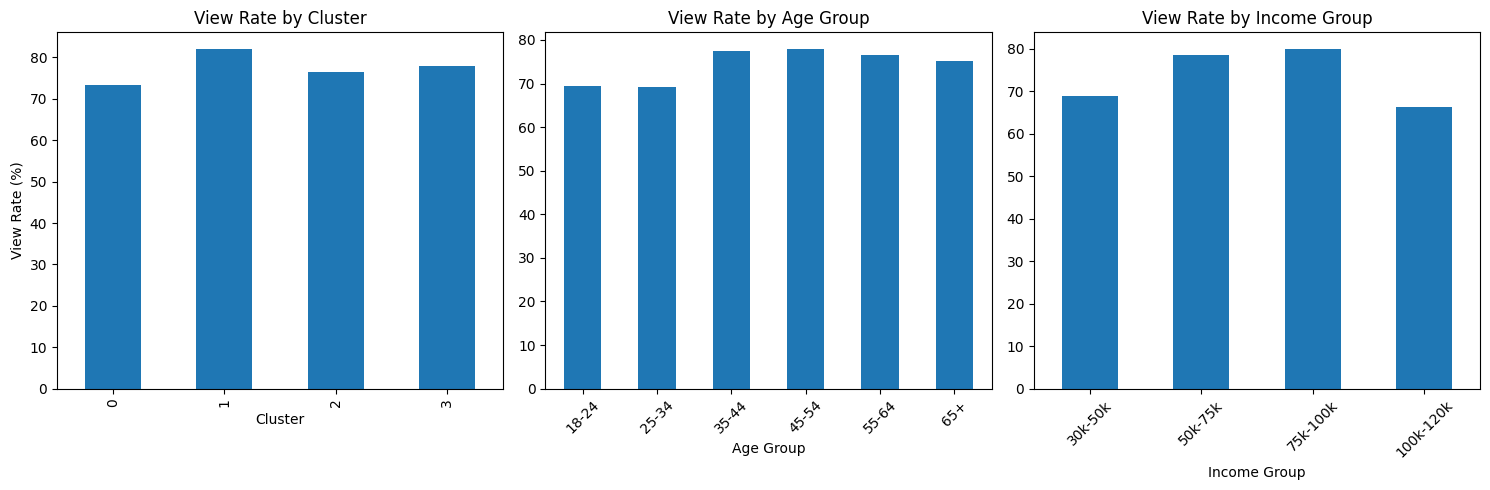

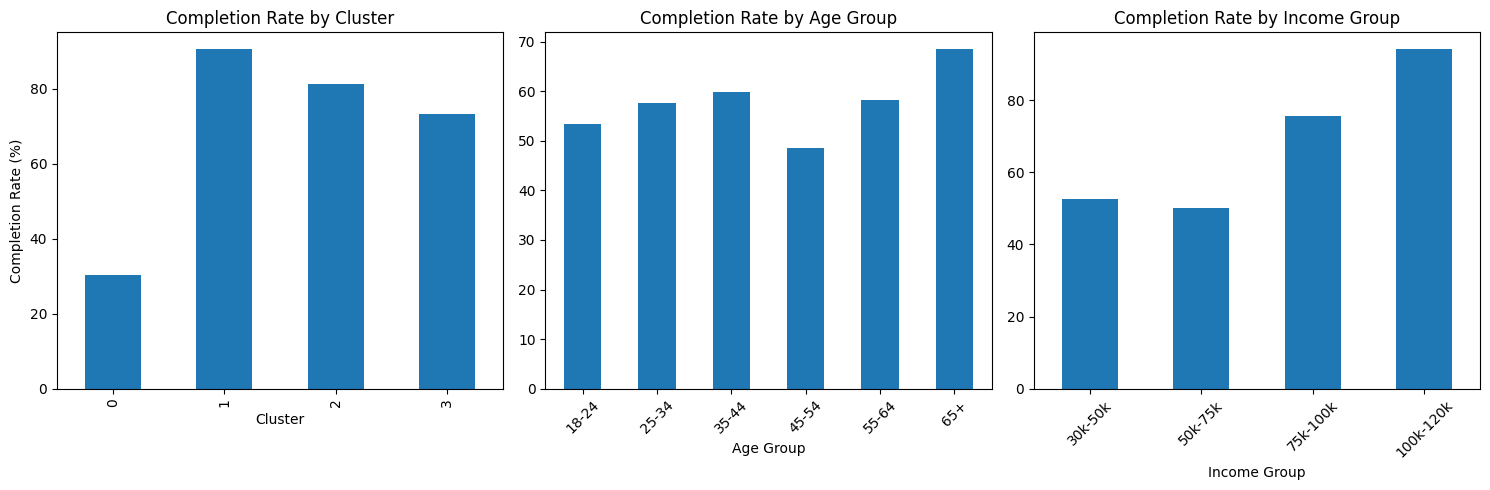

In [ ]:
# 3. Visualizations
# 3.1 View Rate Comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
cluster_response['View Rate (%)'].plot(kind='bar')
plt.title('View Rate by Cluster', fontsize=12)
plt.xlabel('Cluster')
plt.ylabel('View Rate (%)')

plt.subplot(1, 3, 2)
age_response['View Rate (%)'].plot(kind='bar')
plt.title('View Rate by Age Group', fontsize=12)
plt.xlabel('Age Group')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
income_response['View Rate (%)'].plot(kind='bar')
plt.title('View Rate by Income Group', fontsize=12)
plt.xlabel('Income Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3.2 Completion Rate Comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
cluster_response['Completion Rate (%)'].plot(kind='bar')
plt.title('Completion Rate by Cluster', fontsize=12)
plt.xlabel('Cluster')
plt.ylabel('Completion Rate (%)')

plt.subplot(1, 3, 2)
age_response['Completion Rate (%)'].plot(kind='bar')
plt.title('Completion Rate by Age Group', fontsize=12)
plt.xlabel('Age Group')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
income_response['Completion Rate (%)'].plot(kind='bar')
plt.title('Completion Rate by Income Group', fontsize=12)
plt.xlabel('Income Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


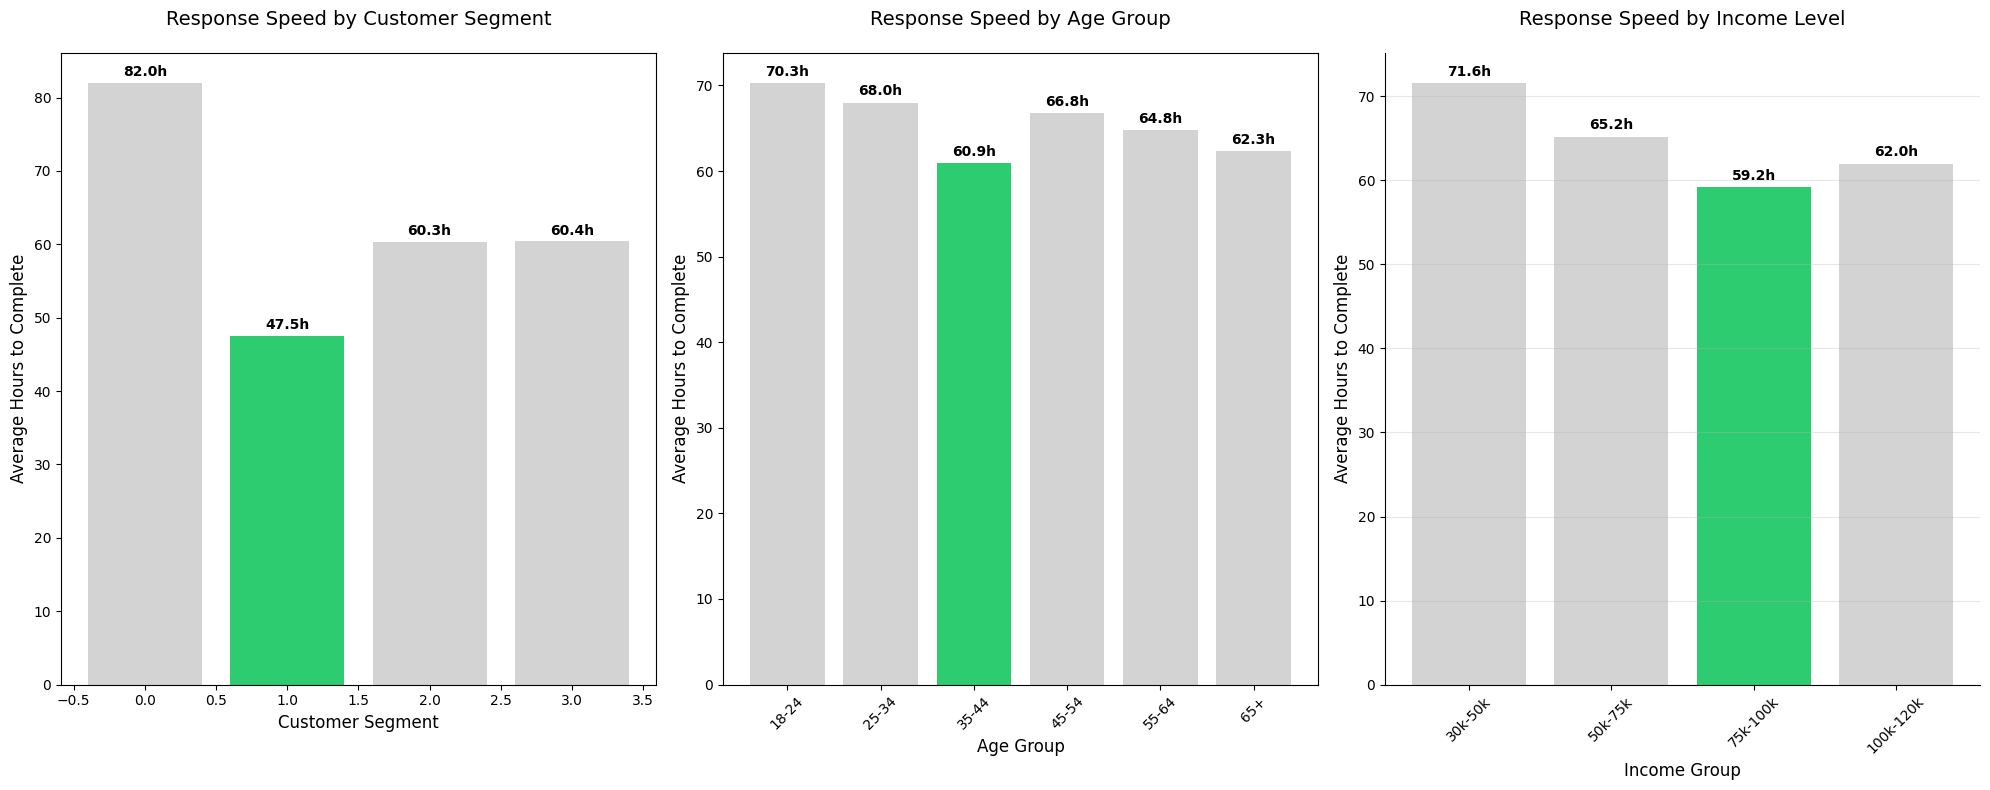


Fastest Responders:
• Age Group: 35-44 (60.9h)
• Income Level: 75k-100k (59.2h)
• Customer Segment: Cluster 1 (47.5h)


In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
values = cluster_response['Avg Hours to Complete']
colors = ['#D3D3D3'] * len(values)  
colors[values.argmin()] = '#2ecc71'  

ax1 = plt.bar(range(len(values)), values, color=colors, width=0.8)
plt.title('Response Speed by Customer Segment', fontsize=14, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average Hours to Complete', fontsize=12)

for i, v in enumerate(values):
    plt.text(i, v + 0.5, f'{v:.1f}h',
             ha='center', va='bottom',
             fontsize=10, fontweight='bold',
             color='black')

plt.subplot(1, 3, 2)
values = age_response['Avg Hours to Complete']
colors = ['#D3D3D3'] * len(values)
colors[values.argmin()] = '#2ecc71'

ax2 = plt.bar(range(len(values)), values, color=colors, width=0.8)
plt.title('Response Speed by Age Group', fontsize=14, pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Hours to Complete', fontsize=12)
plt.xticks(range(len(age_response.index)), age_response.index, rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.5, f'{v:.1f}h',
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.subplot(1, 3, 3)
values = income_response['Avg Hours to Complete']
colors = ['#D3D3D3'] * len(values)
colors[values.argmin()] = '#2ecc71'

ax3 = plt.bar(range(len(values)), values, color=colors, width=0.8)
plt.title('Response Speed by Income Level', fontsize=14, pad=20)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Average Hours to Complete', fontsize=12)
plt.xticks(range(len(income_response.index)), income_response.index, rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.5, f'{v:.1f}h',
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')
for ax in [plt.gca()]:
    ax.grid(True, axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nFastest Responders:")
print(f"• Age Group: {age_response['Avg Hours to Complete'].idxmin()} ({age_response['Avg Hours to Complete'].min():.1f}h)")
print(f"• Income Level: {income_response['Avg Hours to Complete'].idxmin()} ({income_response['Avg Hours to Complete'].min():.1f}h)")
print(f"• Customer Segment: Cluster {cluster_response['Avg Hours to Complete'].idxmin()} ({cluster_response['Avg Hours to Complete'].min():.1f}h)")

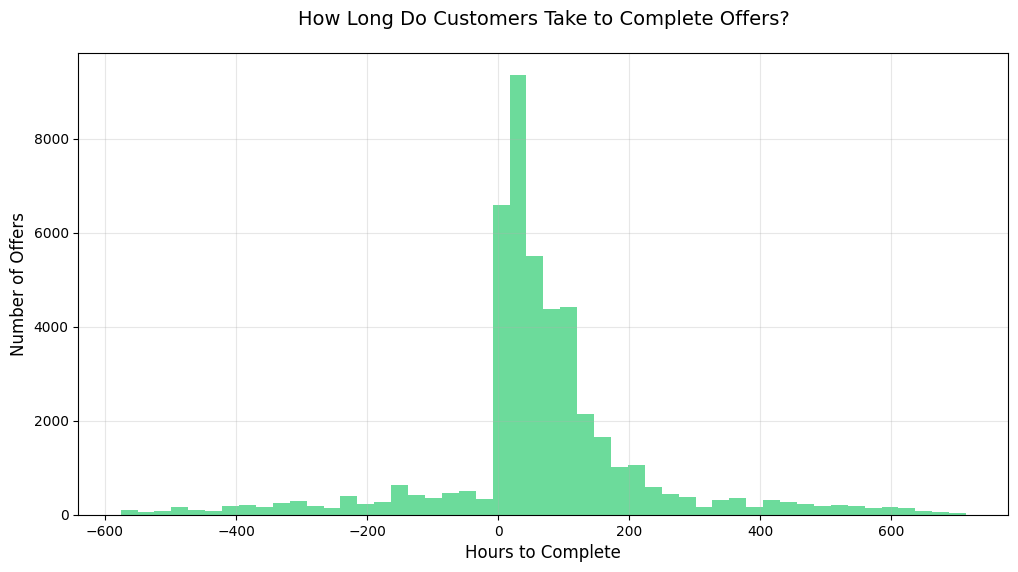

Average response time: 64.5 hours
Fastest response: -576.0 hours
Slowest response: 714.0 hours


In [ ]:
# Calculate response times using merge
received_offers = response_data[response_data['event'] == 'offer received'][['customer_id', 'offer_id', 'time']]
completed_offers = response_data[response_data['event'] == 'offer completed'][['customer_id', 'offer_id', 'time']]

# Merge to match received with completed
matched_offers = pd.merge(
    received_offers,
    completed_offers,
    on=['customer_id', 'offer_id'],
    suffixes=('_received', '_completed')
)

# Calculate time differences
response_times = matched_offers['time_completed'] - matched_offers['time_received']

plt.figure(figsize=(12, 6))
plt.hist(response_times, bins=50, color='#2ecc71', alpha=0.7)
plt.title('How Long Do Customers Take to Complete Offers?', fontsize=14, pad=20)
plt.xlabel('Hours to Complete', fontsize=12)
plt.ylabel('Number of Offers', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average response time: {response_times.mean():.1f} hours")
print(f"Fastest response: {response_times.min():.1f} hours")
print(f"Slowest response: {response_times.max():.1f} hours")

In [ ]:
# 5. Print Summary Statistics
print("\n=== Response Time Summary ===")
response_times = pd.Series(response_times)
print("\nResponse Time Statistics (hours):")
print(response_times.describe().round(2))



=== Response Time Summary ===

Response Time Statistics (hours):
count    46152.00
mean        64.55
std        162.49
min       -576.00
25%         12.00
50%         54.00
75%        114.00
max        714.00
dtype: float64


In [ ]:
print("Columns in response_data:", response_data.columns.tolist())

# Merge với offers để có offer_type
response_data = pd.merge(
    response_data,
    offers[['offer_id', 'offer_type']],
    on='offer_id',
    how='left'
)
offer_metrics = response_data.groupby(['offer_type', 'event']).size().unstack(fill_value=0)
print("\nOffer metrics by type:")
print(offer_metrics)
received = response_data[response_data['event'] == 'offer received'][['customer_id', 'offer_id', 'time', 'offer_type']]
completed = response_data[response_data['event'] == 'offer completed'][['customer_id', 'offer_id', 'time', 'offer_type']]

matched = pd.merge(
    received,
    completed,
    on=['customer_id', 'offer_id', 'offer_type'],
    suffixes=('_received', '_completed')
)

avg_response_times = matched.groupby('offer_type').apply(
    lambda x: (x['time_completed'] - x['time_received']).mean()
).round(1)

print("\nAverage response times by offer type (hours):")
print(avg_response_times)

Columns in response_data: ['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward', 'day', 'valid_completion', 'Cluster', 'Age_Group', 'Income_Group']

Offer metrics by type:
event          offer completed  offer received  offer viewed
offer_type                                                  
bogo                     15669           30499         25449
discount                 17910           30543         21445
informational                0           15235         10831

Average response times by offer type (hours):
offer_type
bogo        53.7
discount    74.0
dtype: float64


In [ ]:
# Phân tích theo offer type
offer_metrics = response_data.groupby(['offer_type', 'event']).size().unstack(fill_value=0)
offer_response = pd.DataFrame()
offer_response['Total Received'] = offer_metrics['offer received']
offer_response['Total Viewed'] = offer_metrics['offer viewed']
offer_response['Total Completed'] = offer_metrics['offer completed']
offer_response['View Rate (%)'] = round(offer_metrics['offer viewed'] / offer_metrics['offer received'] * 100, 2)
offer_response['Completion Rate (%)'] = round(offer_metrics['offer completed'] / offer_metrics['offer viewed'] * 100, 2)

# Tính response time
received = response_data[response_data['event'] == 'offer received'][['customer_id', 'offer_id', 'time', 'offer_type']]
completed = response_data[response_data['event'] == 'offer completed'][['customer_id', 'offer_id', 'time', 'offer_type']]

# Merge và tính thời gian
matched = pd.merge(received, completed,
                 on=['customer_id', 'offer_id', 'offer_type'],
                 suffixes=('_received', '_completed'))
matched['response_time'] = matched['time_completed'] - matched['time_received']

avg_times = matched.groupby('offer_type')['response_time'].mean()
offer_response['Avg Hours to Complete'] = avg_times.round(1)

print("\n=== Response Analysis by Offer Type ===")
print(offer_response)
print("\n=== Fastest Responding Segments ===")
print("\nBy Cluster:")
print(cluster_response.sort_values('Avg Hours to Complete')[['Avg Hours to Complete', 'Completion Rate (%)']])
print("\nBy Age Group:")
print(age_response.sort_values('Avg Hours to Complete')[['Avg Hours to Complete', 'Completion Rate (%)']])
print("\nBy Income Group:")
print(income_response.sort_values('Avg Hours to Complete')[['Avg Hours to Complete', 'Completion Rate (%)']])


=== Response Analysis by Offer Type ===
               Total Received  Total Viewed  Total Completed  View Rate (%)  \
offer_type                                                                    
bogo                    30499         25449            15669          83.44   
discount                30543         21445            17910          70.21   
informational           15235         10831                0          71.09   

               Completion Rate (%)  Avg Hours to Complete  
offer_type                                                 
bogo                         61.57                   53.7  
discount                     83.52                   74.0  
informational                 0.00                    NaN  

=== Fastest Responding Segments ===

By Cluster:
         Avg Hours to Complete  Completion Rate (%)
Cluster                                            
1                         47.5                90.51
2                         60.3                81.18
3    

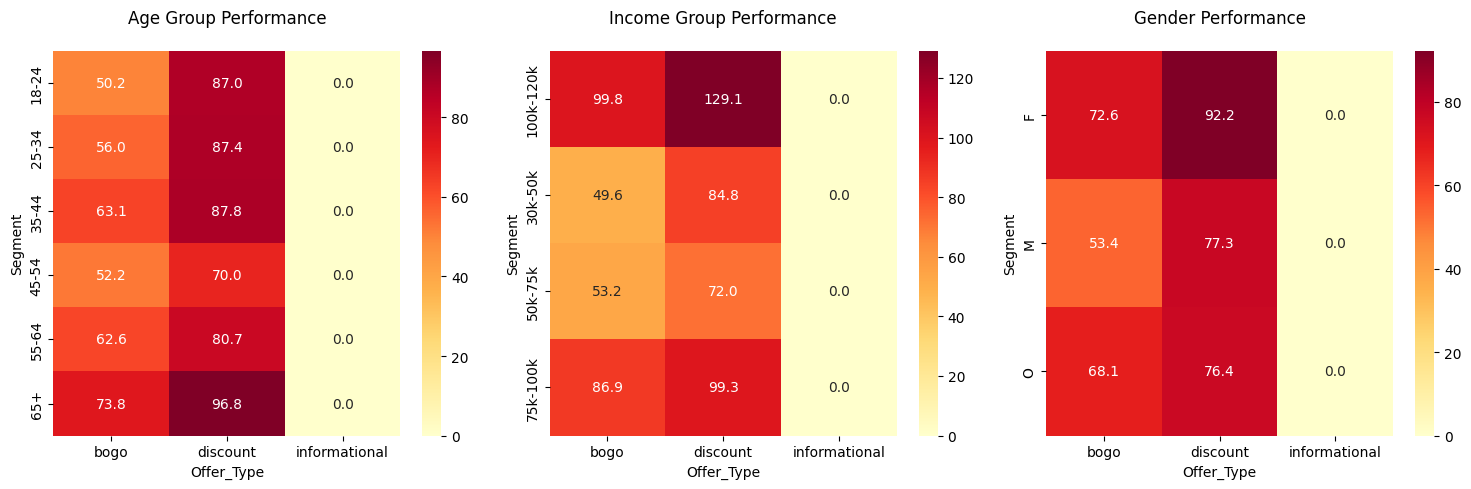


Top Performing Combinations:
                                 Segment_Type    Segment Offer_Type  \
Income_Group_100k-120k_discount  Income_Group  100k-120k   discount   
Income_Group_100k-120k_bogo      Income_Group  100k-120k       bogo   
Income_Group_75k-100k_discount   Income_Group   75k-100k   discount   
Age_Group_65+_discount              Age_Group        65+   discount   
gender_F_discount                      gender          F   discount   

                                 Completion_Rate  
Income_Group_100k-120k_discount           129.11  
Income_Group_100k-120k_bogo                99.85  
Income_Group_75k-100k_discount             99.34  
Age_Group_65+_discount                     96.75  
gender_F_discount                          92.18  


In [ ]:
response_data = pd.merge(
   response_data,
   customers_processed[['customer_id', 'age', 'income', 'gender']],
   on='customer_id',
   how='left'
)

interaction_metrics = pd.DataFrame()

# 1. Group các segment và offer type
segments = ['Age_Group', 'Income_Group', 'gender']
for segment in segments:
   grouped = response_data.groupby([segment, 'offer_type', 'event']).size().unstack(fill_value=0)
   for (seg, offer) in grouped.index:
       key = f"{segment}_{seg}_{offer}"
       received = grouped.loc[(seg, offer), 'offer received']
       viewed = grouped.loc[(seg, offer), 'offer viewed']
       completed = grouped.loc[(seg, offer), 'offer completed']

       interaction_metrics.loc[key, 'Segment_Type'] = segment
       interaction_metrics.loc[key, 'Segment'] = seg
       interaction_metrics.loc[key, 'Offer_Type'] = offer
       interaction_metrics.loc[key, 'View_Rate'] = round(viewed/received * 100, 2)
       interaction_metrics.loc[key, 'Completion_Rate'] = round(completed/viewed * 100, 2) if viewed > 0 else 0

plt.figure(figsize=(15, 5))

# Age-Offer Performance
plt.subplot(131)
age_metrics = interaction_metrics[interaction_metrics['Segment_Type'] == 'Age_Group']
pivot_age = age_metrics.pivot(index='Segment', columns='Offer_Type', values='Completion_Rate')
sns.heatmap(pivot_age, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Age Group Performance', pad=20)

# Income-Offer Performance
plt.subplot(132)
income_metrics = interaction_metrics[interaction_metrics['Segment_Type'] == 'Income_Group']
pivot_income = income_metrics.pivot(index='Segment', columns='Offer_Type', values='Completion_Rate')
sns.heatmap(pivot_income, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Income Group Performance', pad=20)

# Gender-Offer Performance
plt.subplot(133)
gender_metrics = interaction_metrics[interaction_metrics['Segment_Type'] == 'gender']
pivot_gender = gender_metrics.pivot(index='Segment', columns='Offer_Type', values='Completion_Rate')
sns.heatmap(pivot_gender, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Gender Performance', pad=20)

plt.tight_layout()
plt.show()

# 3. Print key insights
print("\nTop Performing Combinations:")
best_completion = interaction_metrics.nlargest(5, 'Completion_Rate')
print(best_completion[['Segment_Type', 'Segment', 'Offer_Type', 'Completion_Rate']])

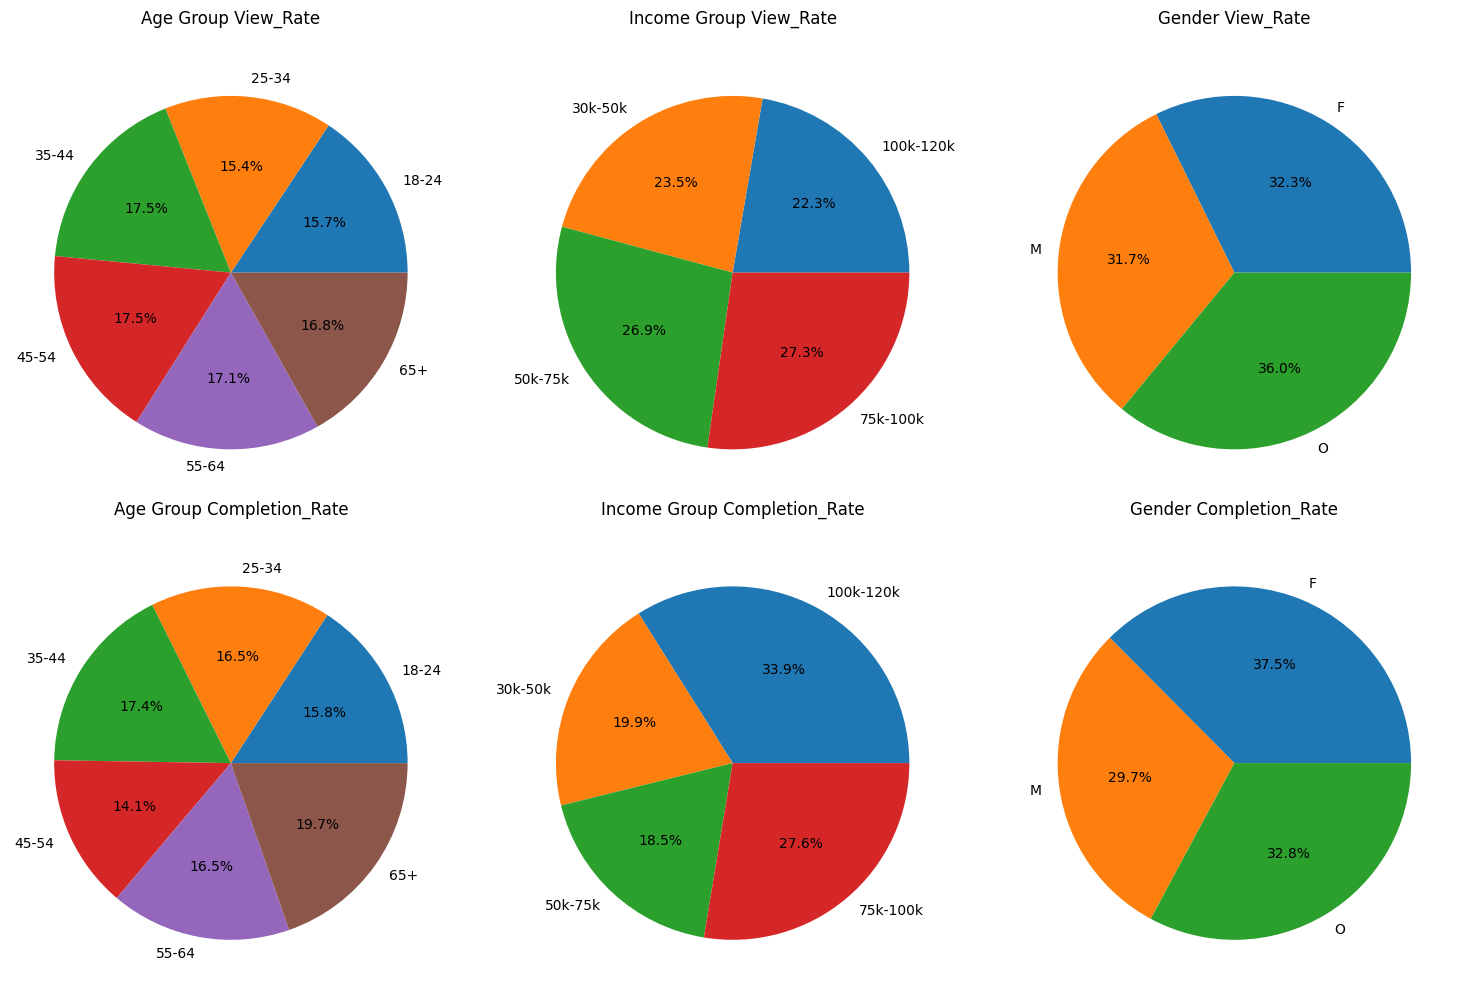

In [ ]:
metrics = ['View_Rate', 'Completion_Rate']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):

   # Age Groups
   plt.subplot(2, 3, i*3 + 1)
   age_data = interaction_metrics[interaction_metrics['Segment_Type'] == 'Age_Group'][['Segment', metric]].groupby('Segment').mean()
   plt.pie(age_data[metric], labels=age_data.index, autopct='%1.1f%%')
   plt.title(f'Age Group {metric}', pad=20)

   # Income Groups
   plt.subplot(2, 3, i*3 + 2)
   income_data = interaction_metrics[interaction_metrics['Segment_Type'] == 'Income_Group'][['Segment', metric]].groupby('Segment').mean()
   plt.pie(income_data[metric], labels=income_data.index, autopct='%1.1f%%')
   plt.title(f'Income Group {metric}', pad=20)

   # Gender
   plt.subplot(2, 3, i*3 + 3)
   gender_data = interaction_metrics[interaction_metrics['Segment_Type'] == 'gender'][['Segment', metric]].groupby('Segment').mean()
   plt.pie(gender_data[metric], labels=gender_data.index, autopct='%1.1f%%')
   plt.title(f'Gender {metric}', pad=20)

plt.tight_layout()
plt.show()